In [1]:
%env TF_KERAS=1

env: TF_KERAS=1


In [1]:
import os

os.environ['SM_FRAMEWORK'] = 'tf.keras'
import sys
import numpy as np
import cv2
import random
from tqdm import tqdm

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import tensorflow as tf
import data_generator

import segmentation_models as sm
from segmentation_models import Unet, Linknet, PSPNet, FPN
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, binary_focal_loss
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Optimizer
sm.set_framework('tf.keras')


# from fast_slic import Slic
# from skimage.segmentation import mark_boundaries, find_boundaries
using_slic = False
# if using_slic:
#     slic = Slic(num_components=1600, compactness=10)
#from mobilenetv2 import MobilenetUnet
#from ghost_net import GhostnetUnet, GhostNet
# from hairsegnet import HairSegNet
# from fast_scnn_org import FastSCNNOrg
# from custom_model import Custom
# from models.PrismaMattingNet import PrismaMattingNet
# from models.FastDeepMatting import FastDeepMatting
# from models.deeplabv3p import Deeplabv3
from models.deeplabv3plus import Deeplabv3
# from models.deeplabv3plus_resnet import Deeplabv3_Resnet
from models.effnet import Effnet
from models_methods import get_unet
from models.unet_mobilenetv2_blur_pool import get_unet_blurpool
from models.unet_mnv1 import MobileNetUnet
from models.mnv1_fpn_se import MobileNetFPNSE
from models.mnv2_fpn_se import MobileNetV2FPNSE
from models.hrnet import HRNet
from models.hlnet import HLNet
from models.enet import ENet
# from models.unet_mobilenetv3 import UnetMobilenetV3
from models.MobileNetV3 import UnetMobilenetV3
from models.dfanet import DFANet
from models.fast_scnn_org import FastSCNNOrg
from models.mobilenet_unet import MobileUnet
from models.bisenetv3 import BiSeNetV3
# import neural_structured_learning as nsl
# from models.tiramisu import create_tiramisu
# from models.tiramisu2 import Tiramisu
# from models_methods import get_unet, get_featurenet
import utils
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Segmentation Models: using `tf.keras` framework.


In [2]:
seed = 0 
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
BASE_DIR = os.getcwd()
project_data_dir = os.path.abspath(os.path.join(BASE_DIR, '..', 'datasets'))
project_dir = os.path.abspath(os.path.join(BASE_DIR, '..'))
print(BASE_DIR)
print(project_data_dir)
print(project_dir)

F:\Work\Orbo\Projects\hair_seg\src
F:\Work\Orbo\Projects\hair_seg\datasets
F:\Work\Orbo\Projects\hair_seg


In [5]:
no_of_epochs = 1000
num_classes = 1
train_batch_size = 4
val_batch_size = 4
# IMAGE_SHAPE = (224, 224, 3)
# IMAGE_SHAPE = (512, 512, 3)
IMAGE_SHAPE = (320, 320, 3)
# IMAGE_SHAPE = (224, 224, 3)
# IMAGE_SHAPE = (256, 320, 3)
# IMAGE_SHAPE = (320, 256, 3)
offset = 0
lr = 1e-2
# IMAGE_SHAPE = (128, 128, 3)
# IMAGE_SHAPE = (192, 192, 3)
# IMAGE_SHAPE = (160, 160, 3)

In [6]:
from albumentations import (
    Compose, HorizontalFlip, HueSaturationValue, RandomResizedCrop,
    RandomBrightnessContrast, RandomContrast, RandomGamma,
    ToFloat, OneOf, IAAAdditiveGaussianNoise, GaussNoise,
    ShiftScaleRotate, MotionBlur, MedianBlur, GaussianBlur,
    CLAHE, IAASharpen, IAAEmboss, OpticalDistortion, Resize, RandomSizedCrop, 
    JpegCompression, RandomScale, ISONoise, RandomCrop, Blur, Equalize)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightnessContrast(p=0.5),
    # HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
    #                    val_shift_limit=10, p=.2),
#     RandomScale(scale_limit=0.06, interpolation=1, p=0.3),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.08, rotate_limit=45, 
                     border_mode=0, p=0.5),
    OpticalDistortion(border_mode=0, p=0.6),
    ISONoise(p=0.6),
    OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.6),
    OneOf([
            MedianBlur(blur_limit=3, p=0.5),
            GaussianBlur(blur_limit=7, p=0.5),
        ], p=0.6),
    MotionBlur(p=0.8),
    JpegCompression(quality_lower=80)
])

train_aug = Compose([
#         OneOf([
#             RandomCrop(IMAGE_SHAPE[0], IMAGE_SHAPE[1], p=0.7),
#             Resize(IMAGE_SHAPE[0], IMAGE_SHAPE[1], p=0.3)
#             ], p=1.0),
        OneOf([
            GaussianBlur(blur_limit=(3, 10), p=0.3),
            MotionBlur(blur_limit=(6, 10), p=0.7)
            ], p=0.6),
        GaussNoise(p=0.5),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        HorizontalFlip(p=0.4),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.08, rotate_limit=30, 
                     border_mode=0, p=0.5)
    ], p=1.0)

hair_aug = Compose([
#         RandomResizedCrop(IMAGE_SHAPE[0], IMAGE_SHAPE[1], scale=(0.3, 1.0)),
#         OneOf([
#                 RandomSizedCrop((IMAGE_SHAPE[0] - 100, IMAGE_SHAPE[1] + 100), IMAGE_SHAPE[0], IMAGE_SHAPE[1], p=0.3),
#                 Resize(IMAGE_SHAPE[0], IMAGE_SHAPE[1], p=0.7)
#         ], p=1.0),
        OneOf([
#             IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.3),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.3),
            Blur(blur_limit=3, p=0.3),
        ],
              p=0.5),
        OneOf([
#             CLAHE(clip_limit=2),
#             IAASharpen(),
#             IAAEmboss(),
            RandomBrightnessContrast(),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.08, rotate_limit=30, 
                     border_mode=0, p=0.5)
        ],
              p=0.4),
        HueSaturationValue(hue_shift_limit=10,val_shift_limit=0,sat_shift_limit=20,p=0.2),
        JpegCompression(quality_lower=60, p=0.3)
#         Equalize(p=1.0)
    ],
                   p=1.0)

val_aug = Compose([
            OneOf([
                RandomSizedCrop((IMAGE_SHAPE[0] - 100, IMAGE_SHAPE[1] + 100), IMAGE_SHAPE[0], IMAGE_SHAPE[1], p=0.3),
                Resize(IMAGE_SHAPE[0], IMAGE_SHAPE[1], p=0.7)
        ], p=1.0)
    ], p=1.0)

FOURTH_CH_AUG = Compose([
    ShiftScaleRotate(shift_limit=0.03, scale_limit=0, rotate_limit=6, border_mode=0, p=1.0)
])

In [7]:
def get_all_file_names(images_dir, masks_dir, small_sample=False):
    files_dir = ''
    image_files = os.listdir(os.path.join(images_dir, files_dir))
    mask_files = os.listdir(os.path.join(masks_dir, files_dir))
    image_files.sort()
    mask_files.sort()

    assert len(image_files) == len(mask_files)
    for im, seg in zip(image_files, mask_files):
        assert (im.split('/')[-1].split(".")[0] == seg.split('/')[-1].split(".")[0])
    image_files = [os.path.join(images_dir, filename) for filename in image_files]
    mask_files = [os.path.join(masks_dir, filename) for filename in mask_files]
    print("Total number of image files: {}".format(len(image_files)))
    print("Total number of mask files: {}".format(len(mask_files)))
    if small_sample:
        return image_files[:500], mask_files[:500]
    return image_files, mask_files

In [8]:
training_images_dir = os.path.join(project_data_dir, 'prepared_data_hair_figaro', 'training_images')
training_masks_dir = os.path.join(project_data_dir, 'prepared_data_hair_figaro', 'training_labels')

validation_images_dir = os.path.join(project_data_dir, 'prepared_data_hair_figaro', 'validation_images')
validation_masks_dir = os.path.join(project_data_dir, 'prepared_data_hair_figaro', 'validation_labels')

training_image_files, training_mask_files = get_all_file_names(training_images_dir, training_masks_dir, small_sample=False)
validation_image_files, validation_mask_files = get_all_file_names(validation_images_dir, validation_masks_dir)

Total number of image files: 3139
Total number of mask files: 3139
Total number of image files: 175
Total number of mask files: 175


In [9]:
def tf_squareit(image):
#     im_shape = image.shape
#     tf.print("Shape of image before sqauring", tf.shape(image))
    [image,] = tf.numpy_function(utils.squareit, [image], [tf.uint8])
#     tf.print("Shape of image after sqauring", tf.shape(image))
#     tf.print("\n")
    image.set_shape(IMAGE_SHAPE)
    return image

In [10]:
def resize(img):
    height, width = img.shape[:2]
    if height >= width:
        hpercent = (IMAGE_SHAPE[0] / height)
        wsize = int((float(width)*float(hpercent)))
        img = cv2.resize(img, (wsize, IMAGE_SHAPE[0]))
    else:
        wpercent = (IMAGE_SHAPE[1] / width)
        hsize = int((float(height) * float(wpercent)))
        img = cv2.resize(img, (IMAGE_SHAPE[1], hsize))
#     tf.print(img.shape)
    
    return img

def resize2(img):
    height, width = img.shape[:2]
    if height <= 300 or width <= 300:
        img = cv2.resize(img, (300, 300))
    
    return img
    

def tf_resize(image):
    [image,] = tf.numpy_function(resize, [image], [tf.uint8])
    image = tf_squareit(image)
    image.set_shape(IMAGE_SHAPE)
    return image

def rgb_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def tf_rgb_to_hsv(image):
    [image,] = tf.numpy_function(rgb_to_hsv, [image], [tf.uint8])
    image.set_shape(IMAGE_SHAPE)
    return image

In [11]:
def val_aug_fn(image, mask):
    aug_data = val_aug(image=image, mask=mask)
    aug_img = aug_data["image"]
#     aug_img = tf.cast(aug_img, tf.float32)
    
    aug_mask = aug_data['mask']
#     aug_mask = tf.cast(aug_mask, tf.float32)
    return aug_img, aug_mask

def tf_val_aug(image, mask):
    im_shape = image.shape
    m_shape = mask.shape
#     [aug_img, aug_mask] = tf.numpy_function(val_aug_fn, [image, mask], [tf.float32, tf.float32])
    [aug_img, aug_mask] = tf.numpy_function(val_aug_fn, [image, mask], [tf.uint8, tf.uint8])
#     aug_img.set_shape([train_batch_size, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3])
#     aug_mask.set_shape([train_batch_size, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3])
    return aug_img, aug_mask

def add_slic(image, mask):
    assignment = slic.iterate(image.astype('uint8'))
#     image = mark_boundaries(image, assignment.astype('uint8'))
    boundaries = find_boundaries(assignment, mode='thick').astype(np.uint8)
    boundaries = np.expand_dims(boundaries, -1)
    image = image / 255.
    image = np.concatenate((image, boundaries), axis=-1)
    return image.astype('float32'), mask

def tf_add_slic(image, mask):
    [image, mask] = tf.numpy_function(add_slic, [image, mask], [tf.float32, tf.float32])
    return image, mask
    

def aug_fn(image, mask):
    aug_data = hair_aug(image=image, mask=mask)
    aug_img = aug_data["image"]
#     aug_img = tf.cast(aug_img, tf.float32)
    
    aug_mask = aug_data['mask']
#     aug_mask = tf.cast(aug_mask, tf.float32)
    return aug_img, aug_mask

def tf_train_aug(image, mask):
    im_shape = image.shape
    m_shape = mask.shape
#     [aug_img, aug_mask] = tf.numpy_function(aug_fn, [image, mask], [tf.float32, tf.float32])
    [aug_img, aug_mask] = tf.numpy_function(aug_fn, [image, mask], [tf.uint8, tf.uint8])
#     aug_img.set_shape([train_batch_size, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3])
#     aug_mask.set_shape([train_batch_size, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3])
    return aug_img, aug_mask

In [12]:
def tf_preprocess_image(image):
#     im_shape = image.shape
#     [image,] = tf.numpy_function(data_generator.preprocess_image, [image, IMAGE_SHAPE], [tf.float32])
#     image.set_shape(im_shape)
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image
    
def tf_preprocess_mask(mask):
#     m_shape = mask.shape
#     [mask,] = tf.numpy_function(data_generator.preprocess_mask, [mask, IMAGE_SHAPE, num_classes], [tf.float32])
#     mask.set_shape([IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1])
    mask = tf.cast(mask, tf.float32)
    mask = mask[:, :, 0]
#     mask = mask / tf.reduce_max(mask)
    mask = mask / 255.
    mask = tf.where(mask < 0.5, 0.0, 1.0)
    mask = tf.expand_dims(mask, -1)
    return mask

In [13]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
#     img = tf_squareit(img)
#     img = tf.image.convert_image_dtype(img, tf.uint8)
    # resize the image to the desired size.
    img = tf_resize(img)
#     return tf.image.resize_with_pad(img, IMAGE_SHAPE[0] + offset, IMAGE_SHAPE[1] + offset, method='nearest')
    return img

In [14]:
def parse_function(filename, label_file):
    image = tf.io.read_file(filename)
    image = decode_img(image)
    
    mask =  tf.io.read_file(label_file)
    mask = decode_img(mask)
    
    return image, mask

In [15]:
def train_preprocess(image, mask):
    image, mask = tf_train_aug(image, mask)
#     image = tf_rgb_to_hsv(image)
    
#     if using_slic:
#         image, mask = tf_add_slic(image, mask)
    
    image = tf_preprocess_image(image)
    
    mask = tf_preprocess_mask(mask)
    
    image.set_shape([*IMAGE_SHAPE[:2], 3])
    mask.set_shape([*IMAGE_SHAPE[:2], 1])
    
    return image, mask

In [16]:
def val_preprocess(image, mask):
#     image = tf.image.resize(image, [IMAGE_SHAPE[0], IMAGE_SHAPE[1]], method='nearest')
#     mask = tf.image.resize(mask, [IMAGE_SHAPE[0], IMAGE_SHAPE[1]], method='nearest')
#     image, mask = tf_val_aug(image, mask)
#     if using_slic:
#         image = tf.cast(image, tf.float32)
#         mask = tf.cast(mask, tf.float32)

#         image, mask = tf_add_slic(image, mask)
    
#     image = tf_rgb_to_hsv(image)
    image = tf_preprocess_image(image)
    
    mask = tf_preprocess_mask(mask)
    
    image.set_shape([*IMAGE_SHAPE[:2], 3])
    mask.set_shape([*IMAGE_SHAPE[:2], 1])
    
    return image, mask

In [17]:
os.cpu_count()

8

In [18]:
def get_dataset(image_files, mask_files, is_train=True):
    if is_train:
        dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files)).shuffle(30000)
    else:
        dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
#     dataset = dataset.map(parse_function, num_parallel_calls=os.cpu_count())
    dataset = dataset.map(parse_function, num_parallel_calls=4)
#     dataset = dataset.map(tf_add_slic, num_parallel_calls=os.cpu_count())
    if is_train:
        dataset = dataset.map(train_preprocess, num_parallel_calls=4)
#         dataset = dataset.cache('caching_file')
#         dataset = dataset.shuffle(2000)
        dataset = dataset.repeat()
        dataset = dataset.batch(train_batch_size)
    else:
        dataset = dataset.map(val_preprocess, num_parallel_calls=4)
        dataset = dataset.repeat()
        dataset = dataset.batch(val_batch_size)
    dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [19]:
def get_overlayed_image(image, label):
    max_val = np.max(label.numpy().reshape(-1, 1), axis=0)
    if max_val > 1:
        max_val = 255.0
    elif max_val <= 1 and max_val > 0:
        max_val = 1.0
    else:
        max_val = 1.0
    label = label.numpy() / float(max_val)
    # mask = np.zeros(shape=(label.shape[0], label.shape[1], 3), dtype=np.uint8)
    # mask[label > 0.5] = [252, 0, 0]
    b = label * 0
    g = label * 0
    r = label * 252

    mask = cv2.merge([r, g, b])
    blended = cv2.addWeighted(utils.denorm_image(image[..., :3].numpy()).astype('uint8'), 1.0, mask.astype('uint8'), 0.5, 0)
#     blended = cv2.addWeighted(image, 1.0, mask.astype('uint8'), 0.5, 0)
    return blended

In [20]:
def display_image_grid(imgs, masks, batch_size):
    fig, ax = plt.subplots(batch_size, 3, figsize=(10, 60))
    for i in range(batch_size):
        image = imgs[i]
#         image = cv2.cvtColor(utils.denorm_image(image[..., :3].numpy()).astype('uint8'), cv2.COLOR_HSV2RGB)
        label = masks[i, :, :, 0]#.astype(np.uint8)
#         print("Shape of label", label.shape)
        overlayed = get_overlayed_image(image, label)
#         print(type(overlayed))
#         print(tf.reduce_max(overlayed))
#         print(overlayed.dtype)
        ax[i, 0].imshow(utils.denorm_image(image[..., :3].numpy()).astype('uint8'))
        ax[i, 0].set_xticklabels([])
        ax[i, 0].set_yticklabels([])
        ax[i, 1].imshow(label, cmap='gray')
        ax[i, 1].set_xticklabels([])
        ax[i, 1].set_yticklabels([])
        ax[i, 2].imshow(overlayed)
        ax[i, 2].set_xticklabels([])
        ax[i, 2].set_yticklabels([])
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

In [21]:
train_dataset = get_dataset(training_image_files, training_mask_files)
val_dataset = get_dataset(validation_image_files, validation_mask_files, is_train=False)

In [23]:
train_gen = iter(train_dataset)

In [24]:
tr_img_batch, tr_lbl_batch = next(train_gen)

In [25]:
print(tr_img_batch.shape)
print(tr_lbl_batch.shape)

(4, 320, 320, 3)
(4, 320, 320, 1)


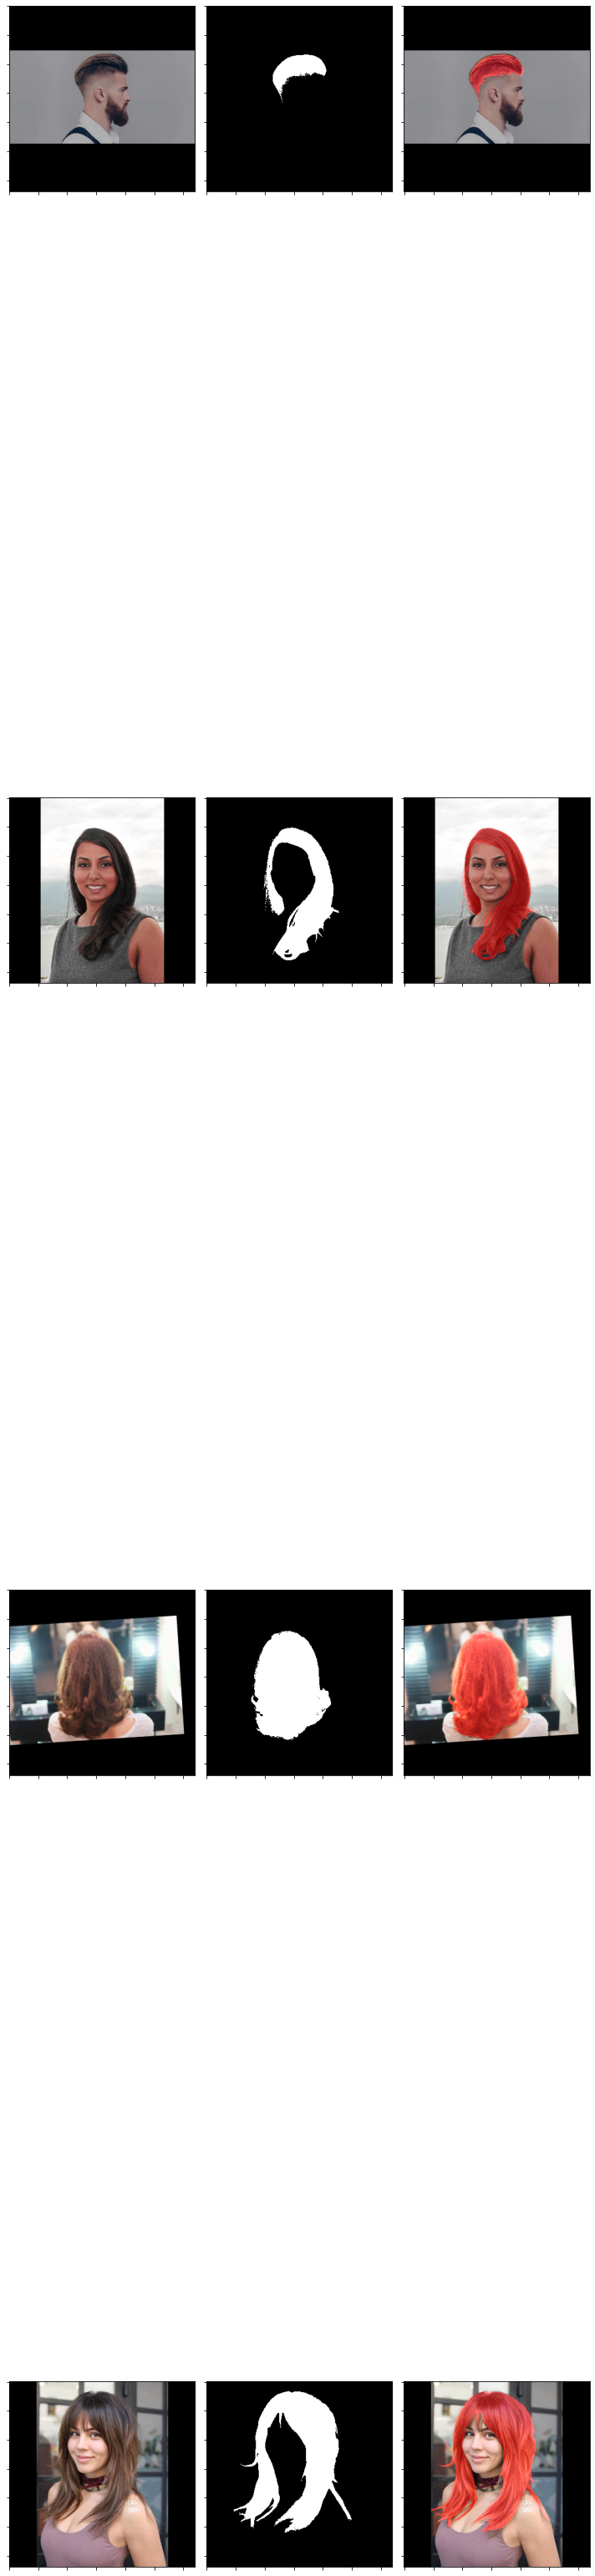

In [26]:
display_image_grid(tr_img_batch, tr_lbl_batch, train_batch_size)

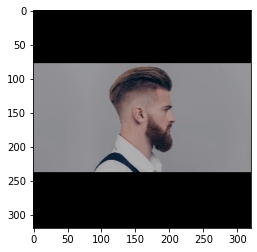

In [27]:
plt.imshow(tr_img_batch[0])

In [28]:
print(type(tr_img_batch[0]))
print(tf.reduce_max(tr_img_batch[0]))
print(tf.reduce_max(tr_lbl_batch[0]))

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.75686276, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


(320, 320, 1)


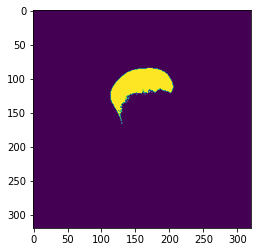

In [29]:
plt.imshow(np.squeeze(tr_lbl_batch[0]))
print(tr_lbl_batch[0].shape)

In [30]:
val_gen = iter(val_dataset)

In [31]:
val_img_batch, val_lbl_batch = next(val_gen)

In [32]:
print(val_img_batch.shape)
print(val_lbl_batch.shape)

(4, 320, 320, 3)
(4, 320, 320, 1)


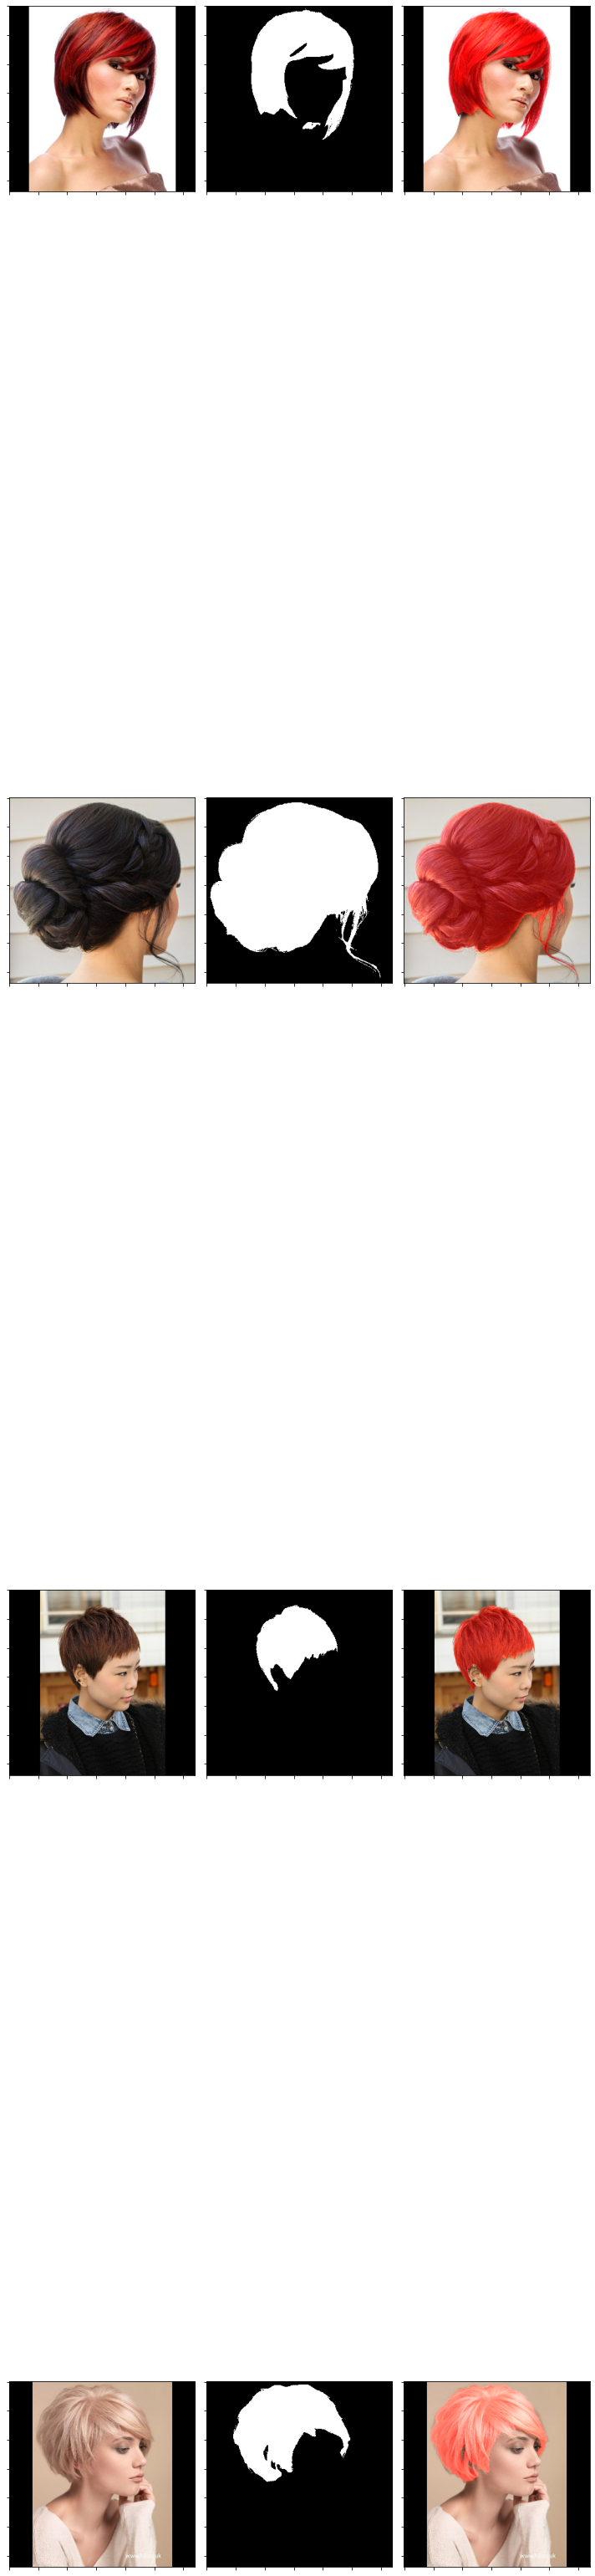

In [33]:
display_image_grid(val_img_batch, val_lbl_batch, val_batch_size)

In [34]:
print(type(val_img_batch[0]))
print(tf.reduce_max(val_img_batch[0]))
print(tf.reduce_max(val_lbl_batch[0]))

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


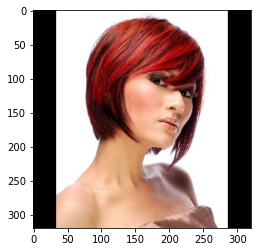

In [35]:
plt.imshow(val_img_batch[0])

(320, 320, 1)


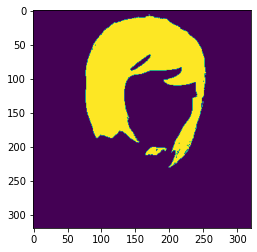

In [36]:
plt.imshow(np.squeeze(val_lbl_batch[0]))
print(val_lbl_batch[0].shape)

In [37]:
del train_gen
del val_gen

In [22]:
from tensorflow.keras.losses import binary_crossentropy
alpha = 0.2
kernel = tf.zeros((15, 15, 1))

# @tf.function
def get_boundary(inp):
    dilated = tf.nn.dilation2d(inp, filters=kernel, strides=(1,1,1,1), dilations=(1,1,1,1), data_format="NHWC", padding="SAME")
    eroded = tf.nn.erosion2d(inp, filters=kernel, strides=(1,1,1,1), dilations=(1,1,1,1), data_format="NHWC", padding="SAME")
    diff = tf.abs(dilated - eroded)
    diff = tf.expand_dims(diff, axis=-1)
    return tf.abs(dilated-eroded)

@tf.function
def refine_loss(logits, image, boundary_target):
    
    gamma1 = 0.5
    gamma2 = 1-gamma1
    factor_lambda= 1.5

    dy_logits, dx_logits = tf.image.image_gradients(logits)
    dy_image, dx_image = tf.image.image_gradients(image)

    # magnitudes of logits and labels gradients
    Mpred = tf.sqrt(tf.square(dy_logits)+tf.square(dx_logits))
    Mimg = tf.sqrt(tf.square(dy_image)+tf.square(dx_image))

    # define cos loss and mag loss
    cosL = (1-tf.abs(dx_image*dx_logits+dy_image*dy_logits))*Mpred
    magL = tf.maximum(factor_lambda*Mimg-Mpred,0)

    # define mask
    M_bound = boundary_target

    # define total refine loss
    refineLoss = (gamma1*cosL + gamma2*magL)*M_bound
    return tf.reduce_mean(refineLoss)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
    
def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
            y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + \
    weighted_dice_loss(y_true, y_pred, weight)
    return loss

def loss_fn(image):
    def custom_loss(label, predictions):
        label_mask = tf.cast(label, tf.float32)
        pred_mask = tf.cast(predictions, tf.float32)

        label_boundary = get_boundary(label_mask)
        pred_boundary = get_boundary(pred_mask)

        rloss = refine_loss(pred_mask, image, label_boundary)
        #b_loss = binary_crossentropy(label, predictions)
        b_w_loss = weighted_bce_dice_loss(label, predictions)

        return  (alpha * rloss) + ((1 - alpha) * b_w_loss)
    return custom_loss

In [23]:
from __future__ import division

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   #strict=True,
                   name="loss"
                   )
    return loss

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def keras_lovasz_hinge(labels,logits):
    return lovasz_hinge(logits, labels, per_image=True, ignore=None)

def focal_loss(y_true, y_pred):
    gamma=0.75
    alpha=0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

    pt_1 = K.clip(pt_1, 1e-3, .999)
    pt_0 = K.clip(pt_0, 1e-3, .999)

    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

def boundary_loss(label, predictions):
    gt_boundary = get_boundary(label)
    pr_boundary = get_boundary(predictions)
#     b_loss = (0.7 * binary_crossentropy(gt_boundary, pr_boundary)) + (0.3 * focal_loss(gt_boundary, pr_boundary))
#     b_loss = (0.5 * binary_crossentropy(gt_boundary, pr_boundary)) + (0.5 * binary_focal_loss(gt_boundary, pr_boundary))
    return binary_focal_loss(gt_boundary, pr_boundary)

# def total_loss(y_true, y_pred):
# #     return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred) + keras_lovasz_hinge(y_true, y_pred) + bce_jaccard_loss(y_true, y_pred)
# #     return (0.2*binary_focal_loss(y_true, y_pred)) + (0.5*dice_loss(y_true, y_pred)) + (0.2*weighted_bce_dice_loss(y_true, y_pred)) + (0.1 * boundary_loss(y_true, y_pred))
# #     return (0.5*dice_loss(y_true, y_pred)) + (0.1*boundary_loss(y_true, y_pred)) + (0.2*binary_crossentropy(y_true, y_pred)) + (0.2*binary_focal_loss(y_true, y_pred))
# #     return (0.9 * dice_loss(y_true, y_pred)) + (0.1 * boundary_loss(y_true, y_pred)) #+ (0.3 * binary_crossentropy(y_true, y_pred))
#    return (0.3 * focal_loss(y_true, y_pred)) + (0.7 * binary_crossentropy(y_true, y_pred))

def total_loss(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
#     final_loss = focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred) + keras_lovasz_hinge(y_true, y_pred) + bce_jaccard_loss(y_true, y_pred)
    final_loss = (0.2*binary_focal_loss(y_true, y_pred)) + (0.5*dice_loss(y_true, y_pred)) + (0.2*weighted_bce_dice_loss(y_true, y_pred)) + (0.1 * boundary_loss(y_true, y_pred))
#     final_loss = (0.5*dice_loss(y_true, y_pred)) + (0.1*boundary_loss(y_true, y_pred)) + (0.2*binary_crossentropy(y_true_flat, y_pred_flat)) + (0.2*binary_focal_loss(y_true, y_pred))
#     final_loss = (0.9 * dice_loss(y_true, y_pred)) + (0.1 * boundary_loss(y_true, y_pred)) #+ (0.3 * binary_crossentropy(y_true_flat, y_pred_flat))
#     final_loss = (0.3 * focal_loss(y_true, y_pred)) + (0.7 * binary_crossentropy(y_true_flat, y_pred_flat))
#     tf.print("Shape of total loss5: ", final_loss.shape, "Value: ", final_loss)
    return final_loss

def IOU(y_true, y_pred):
    
    smooth = 1e-6
    y_true ,y_pred = tf.reshape(y_true, [-1]),tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_pred * y_true) + smooth
    union = tf.reduce_sum(y_pred+y_true) - inter + smooth
    return inter / union

def dice(y_true, y_pred):
    
    smooth = 1e-6
#     y_true ,y_pred = tf.reshape(y_true, [-1]),tf.reshape(y_pred, [-1])
    inter = 2.*tf.reduce_sum(y_pred * y_true) + smooth
    sum_ = tf.reduce_sum(y_pred+y_true) + smooth
    return inter / sum_

def hair_loss(y_true, y_pred):
    y_true ,y_pred = tf.reshape(y_true, [-1]),tf.reshape(y_pred, [-1])
#     y_pred = tf.math.sigmoid(y_pred)
    bce = binary_crossentropy(y_true, y_pred, from_logits=True)
    y_pred = tf.math.sigmoid(y_pred)
    y_pred = tf.where(y_pred < 0.5, 0.0, 1.0)
    d_loss = 1. - dice(y_true,y_pred)
    final_loss = (1 * bce) + (3 * d_loss)
#     tf.print("Shape of hair loss: ", final_loss.shape, "Value: ", final_loss)
    return final_loss

def matting_loss(image, mask):
    image = tf.image.rgb_to_grayscale(image)
    sobel_kernel_x = tf.constant([[1.0, 0.0, -1.0],
                                  [2.0, 0.0, -2.0],
                                  [1.0, 0.0, -1.0]], dtype=tf.float32)
    sobel_kernel_x = tf.expand_dims(sobel_kernel_x, -1)
    sobel_kernel_x = tf.expand_dims(sobel_kernel_x, -1)
    # print(sobel_kernel_x.shape)
    # print(image.shape)
    I_x = tf.nn.conv2d(image, sobel_kernel_x, strides=[1, 1, 1, 1], padding='SAME')
    M_x = tf.nn.conv2d(mask, sobel_kernel_x, strides=[1, 1, 1, 1], padding='SAME')

    sobel_kernel_y = tf.constant([[1.0, 2.0, 1.0],
                                  [0.0, 0.0, 0.0],
                                  [-1.0, -2.0, -1.0]], dtype=tf.float32)
    sobel_kernel_y = tf.expand_dims(sobel_kernel_y, -1)
    sobel_kernel_y = tf.expand_dims(sobel_kernel_y, -1)
    I_y = tf.nn.conv2d(image, sobel_kernel_y, 1, padding='SAME')
    M_y = tf.nn.conv2d(mask, sobel_kernel_y, 1, padding='SAME')

    # I_x = I_x / tf.math.reduce_max(I_x)
    # I_y = I_y / tf.math.reduce_max(I_y)
    # M_x = M_x / tf.math.reduce_max(M_x)
    # M_y = M_y / tf.math.reduce_max(M_y)

#     I_x, I_y = tf.image.image_gradients(image)
#     M_x, M_y = tf.image.image_gradients(mask)

    M_mag = tf.sqrt(tf.pow(M_x, 2) + tf.pow(M_y, 2) + 1e-8)
    temp = 1 - (tf.pow((I_x * M_x) + (I_y * M_y), 2))
    temp = tf.where(temp > 0, temp, 0.0)

    loss = (tf.reduce_sum(M_mag * temp) / tf.reduce_sum(M_mag)) + 1e-6
    return loss

In [115]:
tr_img_batch, tr_lbl_batch = next(train_gen)

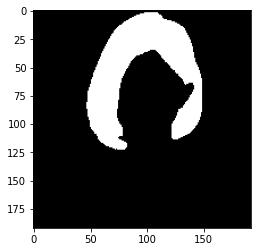

In [116]:
plt.imshow(tr_lbl_batch[2][..., 0], cmap='gray')

Max-Min of I_x: tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(-1.0291255, shape=(), dtype=float32)
Max-Min of M_x: tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(-1.0, shape=(), dtype=float32)
Max-Min of I_y: tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(-1.0477484, shape=(), dtype=float32)
Max-Min of M_y: tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(-1.0, shape=(), dtype=float32)
Max-Min of temp: tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.19543368, shape=(), dtype=float32)
tf.Tensor(0.961158, shape=(), dtype=float32)


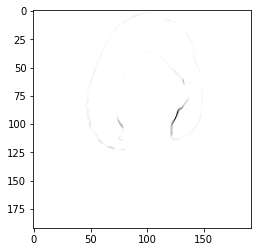

In [121]:
loss, gr = matting_loss(np.expand_dims(tr_img_batch[2], 0), np.expand_dims(tr_lbl_batch[2], 0))
print(loss)
plt.imshow(gr[0, :, :, 0], cmap='gray')

In [83]:
loss, gr = matting_loss(tr_img_batch, tr_lbl_batch)
print(loss)

Max-Min of I_x: tf.Tensor(3.964594, shape=(), dtype=float32) tf.Tensor(-3.9839153, shape=(), dtype=float32)
Max-Min of M_x: tf.Tensor(4.0, shape=(), dtype=float32) tf.Tensor(-4.0, shape=(), dtype=float32)
Max-Min of I_y: tf.Tensor(3.888979, shape=(), dtype=float32) tf.Tensor(-3.9480267, shape=(), dtype=float32)
Max-Min of M_y: tf.Tensor(4.0, shape=(), dtype=float32) tf.Tensor(-4.0, shape=(), dtype=float32)
Max-Min of temp: tf.Tensor(187.69843, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(9.3018675, shape=(), dtype=float32)


In [38]:
K.clear_session()
def conv_block(x, filters, name='layer'):
    x = tf.keras.layers.SeparableConv2D(filters,
                                 kernel_size=(3, 3),
                                 use_bias=False,
                                 depthwise_initializer='he_normal',
                                 pointwise_initializer='he_normal',
                                 padding='same',
                                 depthwise_regularizer='l2',
                                 pointwise_regularizer='l2',
                                 name='sep_' + name)(x)
#     x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', 
#                                 kernel_initializer='he_normal',
#                                 name='conv_full_' + name,
#                                 kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization(name='sep_bn_' + name)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def conv_pw(x, filters, name='layer'):
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                        padding='same',
                        kernel_initializer='he_normal',
                        name='conv_pw_' + name,
                        kernel_regularizer='l2')(x)
    return x


def get_upblock(x, mm, mm_n, name='4'):

    x = conv_pw(x, filters=32, name='upblock_' + name + 'b')
    x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name='upsample_' + name)(x)
    y = mm.get_layer(name=mm_n).output
    y = conv_pw(y, 32, name='upblock_' + name)
    x = tf.keras.layers.add([y, x], name='add_' + name)

    x = conv_block(x, filters=32, name='upblock_conv' + name + 'b')

    # x = tf.keras.layers.BatchNormalization(name='upblock_bn_' + name)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    return x

class HardSigmoid(tf.keras.layers.Layer):
    def __init__(self, name="HardSigmoid", **kwargs):
        super(HardSigmoid, self).__init__(name=name, **kwargs)
        self.relu6 = tf.keras.layers.ReLU(max_value=6, name="ReLU6", **kwargs)

    def call(self, input):
        return self.relu6(input + 3.0) / 6.0

    def get_config(self):
        base_config = super(HardSigmoid, self).get_config()
        return dict(list(base_config.items()))

def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w = tf.keras.backend.int_shape(input_tensor)[2]
    h = tf.keras.backend.int_shape(input_tensor)[1]

    for bin_size in bin_sizes:
        x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
        x = tf.keras.layers.SeparableConv2D(128, 3, 2, padding='same')(x)
        x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)

        concat_list.append(x)

    return tf.keras.layers.concatenate(concat_list)

def se_block(input_tensor, block):
    _, h, w, c = input_tensor.shape
    input_channels = int(input_tensor.shape[-1])
    x = tf.nn.avg_pool2d(input_tensor, ksize=(input_tensor.shape[1], input_tensor.shape[2]), padding='VALID', strides=(1, 1), name=f'AvgPool{h}x{w}_{block}')
    x = tf.keras.layers.Dense(units=c//4, activation="relu", use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Squeeze_{block}")(x)
    x = tf.keras.layers.Dense(units=c, activation=HardSigmoid(), use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Excite_{block}")(x)
    x = tf.keras.layers.Reshape((1, 1, c), name=f'Reshape_None_1_1_{c}_{block}')(x)
    return input_tensor * x

mnet = tf.keras.applications.MobileNetV3Small(input_shape=IMAGE_SHAPE, include_top=False, minimalistic=True)
# mnet.summary()
base = tf.keras.models.Model(mnet.input, mnet.get_layer("re_lu_10").output)
skips = ["re_lu_3",  #28x28
         "re_lu_1"]#,     #56x56
         #"re_lu"]    #112x112

x = get_upblock(base.output, base, skips[0], name='3') #14x14
x = get_upblock(x, base, skips[1], name='2') #28x28
# x = get_upblock(x, base, skips[2], name='1') #56x56
# x = get_upblock(x, base, skips[3], name='1') #112x112

x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear', name='upblock_0')(x)
# x = conv_block(x, 3, name='last_conv')
logits = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='logits')(x)
act = tf.keras.layers.Activation('sigmoid')(logits)
model = tf.keras.models.Model(mnet.input, act)
model.summary(112)

AttributeError: module 'tensorflow.keras.applications' has no attribute 'MobileNetV3Small'

In [24]:
# K.clear_session()

# def up_block(x, skip, n=32, interpolation='bilinear'):
#     if skip is not None:
# #         x = tf.keras.layers.Concatenate()([x, skip])
#         if not skip.shape[-1] == x.shape[-1]:
#             skip = tf.keras.layers.Conv2D(x.shape[-1], 1, padding="same")(skip)
#         x = tf.keras.layers.Add()([x, skip])
#     x = tf.keras.layers.SeparableConv2D(n, (3,3), padding="same", activation="relu")(x)
#     x = tf.keras.layers.UpSampling2D(interpolation=interpolation)(x)
#     return x

# def pyramid_pooling_block(input_tensor, bin_sizes):
#     concat_list = [input_tensor]
#     w = tf.keras.backend.int_shape(input_tensor)[2]
#     h = tf.keras.backend.int_shape(input_tensor)[1]

#     for bin_size in bin_sizes:
#         x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
#         x = tf.keras.layers.SeparableConv2D(128, 3, 2, padding='same')(x)
#         x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)

#         concat_list.append(x)

#     return tf.keras.layers.concatenate(concat_list)

# mnet = tf.keras.applications.MobileNetV2(
#     input_shape=(192, 192, 3), 
#     include_top=False, 
#     alpha=1.0
# )
# base = tf.keras.models.Model(mnet.input, mnet.get_layer("block_13_depthwise_relu").output) #6x6

# skips = [base.get_layer("block_13_expand_relu").output, #12x12
#          base.get_layer("block_6_expand_relu").output,  #24x24
#          base.get_layer("block_3_expand_relu").output,  #48x48
#          base.get_layer("block_1_expand_relu").output]  #96x96

# gfe_layer1 = pyramid_pooling_block(base.output, [2, 4, 6]) #6x6

# x = tf.keras.layers.UpSampling2D(interpolation="nearest")(gfe_layer1) #12x12
# x = up_block(x, skips[0], 32) #24x24
# x = pyramid_pooling_block(x, [2, 4, 6, 8]) #24x24
# x = up_block(x, skips[1], 32) #48x48
# x = pyramid_pooling_block(x, [2, 4, 6, 8]) #48x48
# x = up_block(x, skips[2], 32) #96x96
# x = pyramid_pooling_block(x, [2, 4, 6, 8]) #96x96
# x = up_block(x, skips[3], 32, interpolation='bilinear') #192x192
# x = pyramid_pooling_block(x, [2, 4, 6, 8]) #192x192

# logits = tf.keras.layers.Conv2D(filters=1,kernel_size=(1, 1),padding='same', name='logits')(x)
# act = tf.keras.layers.Activation('sigmoid')(logits)
# model = tf.keras.models.Model(mnet.input, act)
# model.summary()

In [25]:
# K.clear_session()

# def up_block(x, skip, n=32, interpolation='bilinear'):
#     if skip is not None:
# #         x = tf.keras.layers.Concatenate()([x, skip])
#         if not skip.shape[-1] == x.shape[-1]:
#             skip = tf.keras.layers.Conv2D(x.shape[-1], 1, padding="same")(skip)
#         x = tf.keras.layers.Add()([x, skip])
#     x = tf.keras.layers.SeparableConv2D(n, (3,3), padding="same", activation="relu")(x)
#     x = tf.keras.layers.UpSampling2D(interpolation=interpolation)(x)
#     return x

# class HardSigmoid(tf.keras.layers.Layer):
#     def __init__(self, name="HardSigmoid", **kwargs):
#         super(HardSigmoid, self).__init__(name=name, **kwargs)
#         self.relu6 = tf.keras.layers.ReLU(max_value=6, name="ReLU6", **kwargs)

#     def call(self, input):
#         return self.relu6(input + 3.0) / 6.0

#     def get_config(self):
#         base_config = super(HardSigmoid, self).get_config()
#         return dict(list(base_config.items()))

# def pyramid_pooling_block(input_tensor, bin_sizes):
#     concat_list = [input_tensor]
#     w = tf.keras.backend.int_shape(input_tensor)[2]
#     h = tf.keras.backend.int_shape(input_tensor)[1]

#     for bin_size in bin_sizes:
#         x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
#         x = tf.keras.layers.SeparableConv2D(128, 3, 2, padding='same')(x)
#         x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)

#         concat_list.append(x)

#     return tf.keras.layers.concatenate(concat_list)

# def se_block(input_tensor, block):
#     _, h, w, c = input_tensor.shape
#     x = tf.keras.layers.GlobalAveragePooling2D(name=f'AvgPool{h}x{w}_{block}')(input_tensor)
#     x = tf.keras.layers.Dense(units=c//4, activation="relu", use_bias=False,
#                               kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Squeeze_{block}")(x)
#     x = tf.keras.layers.Dense(units=c, activation=HardSigmoid(), use_bias=False,
#                               kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Excite_{block}")(x)
#     x = tf.keras.layers.Reshape((1, 1, c), name=f'Reshape_None_1_1_{c}_{block}')(x)
#     return input_tensor * x

# ip_tensor = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='image')

# mnet = tf.keras.applications.MobileNetV2(
#     input_shape=(192, 192, 3),
#     input_tensor=ip_tensor,
#     include_top=False, 
#     alpha=1.0
# )
# base = tf.keras.models.Model(mnet.input, mnet.get_layer("block_13_depthwise_relu").output) #6x6

# skips = [base.get_layer("block_13_expand_relu").output, #12x12
#          base.get_layer("block_6_expand_relu").output,  #24x24
#          base.get_layer("block_3_expand_relu").output,  #48x48
#          base.get_layer("block_1_expand_relu").output]  #96x96

# x = se_block(base.output, 0) #6x6
# x = se_block(x, 1)
# x = se_block(x, 2)

# x = tf.keras.layers.UpSampling2D(interpolation="nearest")(x) #12x12
# x = up_block(x, skips[0], 32) #24x24
# x = se_block(x, 3) #24x24
# x = se_block(x, 4)
# x = pyramid_pooling_block(x, [2, 4, 6, 8]) #24x24
# x = up_block(x, skips[1], 32) #48x48
# x = se_block(x, 5) #48x48
# x = pyramid_pooling_block(x, [2, 4, 6, 8]) #48x48
# x = up_block(x, skips[2], 32) #96x96
# # x = pyramid_pooling_block(x, [2, 4, 6, 8]) #96x96
# x = up_block(x, skips[3], 32, interpolation='bilinear') #192x192

# logits = tf.keras.layers.Conv2D(filters=1,kernel_size=(1, 1),padding='same', name='logits')(x)
# act = tf.keras.layers.Activation('sigmoid')(logits)
# model = tf.keras.models.Model(mnet.input, act)
# model.summary()

In [26]:
# K.clear_session()

# def up_block(x, skip, n=32, interpolation='bilinear'):
#     if skip is not None:
# #         x = tf.keras.layers.Concatenate()([x, skip])
#         if not skip.shape[-1] == x.shape[-1]:
#             skip = tf.keras.layers.Conv2D(x.shape[-1], 1, padding="same")(skip)
#         x = tf.keras.layers.Add()([x, skip])
#     x = tf.keras.layers.SeparableConv2D(n, (3,3), padding="same", activation="relu")(x)
#     x = tf.keras.layers.UpSampling2D(interpolation=interpolation)(x)
#     return x

# class HardSigmoid(tf.keras.layers.Layer):
#     def __init__(self, name="HardSigmoid", **kwargs):
#         super(HardSigmoid, self).__init__(name=name, **kwargs)
#         self.relu6 = tf.keras.layers.ReLU(max_value=6, name="ReLU6", **kwargs)

#     def call(self, input):
#         return self.relu6(input + 3.0) / 6.0

#     def get_config(self):
#         base_config = super(HardSigmoid, self).get_config()
#         return dict(list(base_config.items()))

# def pyramid_pooling_block(input_tensor, bin_sizes):
#     concat_list = [input_tensor]
#     w = tf.keras.backend.int_shape(input_tensor)[2]
#     h = tf.keras.backend.int_shape(input_tensor)[1]

#     for bin_size in bin_sizes:
#         x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
#         x = tf.keras.layers.SeparableConv2D(128, 3, 2, padding='same')(x)
#         x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)

#         concat_list.append(x)

#     return tf.keras.layers.concatenate(concat_list)

# def se_block(input_tensor, block):
#     _, h, w, c = input_tensor.shape
#     x = tf.keras.layers.GlobalAveragePooling2D(name=f'AvgPool{h}x{w}_{block}')(input_tensor)
#     x = tf.keras.layers.Dense(units=c//4, activation="relu", use_bias=False,
#                               kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Squeeze_{block}")(x)
#     x = tf.keras.layers.Dense(units=c, activation=HardSigmoid(), use_bias=False,
#                               kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Excite_{block}")(x)
#     x = tf.keras.layers.Reshape((1, 1, c), name=f'Reshape_None_1_1_{c}_{block}')(x)
#     return input_tensor * x

# ip_tensor = tf.keras.layers.Input(shape=(IMAGE_SHAPE), name='image')
# mnet = tf.keras.applications.MobileNetV2(
#     input_shape=(192, 192, 3),
#     input_tensor=ip_tensor,
#     include_top=False, 
#     alpha=0.35
# )
# base = tf.keras.models.Model(mnet.input, mnet.get_layer("block_13_expand_relu").output) #12x12

# skips = [
# #          base.get_layer("block_13_expand_relu").output, #12x12
#          base.get_layer("block_6_expand_relu").output,  #24x24
#          base.get_layer("block_3_expand_relu").output,  #48x48
#          base.get_layer("block_1_expand_relu").output]  #96x96

# x = pyramid_pooling_block(base.output, [2, 4, 6, 8]) #12x12
# x = se_block(x, 0) #12x12
# x = se_block(x, 1) #12x12
# x = se_block(x, 2) #12x12

# x = tf.keras.layers.UpSampling2D(interpolation="bilinear")(x) #24x24
# x = up_block(x, skips[0], 32) #48x48
# x = se_block(x, 3) #48x48
# x = se_block(x, 4)
# x = up_block(x, skips[1], 32) #96x96
# x = se_block(x, 5) #96x96
# x = up_block(x, skips[2], 32, interpolation='bilinear') #192x192

# logits = tf.keras.layers.Conv2D(filters=1,kernel_size=(1, 1),padding='same', name='logits')(x)
# act = tf.keras.layers.Activation('sigmoid')(logits)
# model = tf.keras.models.Model(mnet.input, act)
# model.summary()

In [27]:
# K.clear_session()

# def conv_block(x, filters, name='layer'):
#     x = tf.keras.layers.SeparableConv2D(filters,
#                                  kernel_size=(3, 3),
#                                  use_bias=False,
#                                  depthwise_initializer='he_normal',
#                                  pointwise_initializer='he_normal',
#                                  padding='same',
#                                  depthwise_regularizer='l2',
#                                  pointwise_regularizer='l2',
#                                  name='sep_' + name)(x)
#     x = tf.keras.layers.BatchNormalization(name='sep_bn_' + name)(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     return x

# def conv_pw(x, filters, name='layer'):
#     x = tf.keras.layers.Conv2D(filters, (1, 1),
#                         padding='same',
#                         kernel_initializer='he_normal',
#                         name='conv_pw_' + name,
#                         kernel_regularizer='l2')(x)
#     return x


# def get_upblock(x, mm, mm_n, name='4'):

#     x = conv_block(x, filters=32, name='upblock_' + name + 'b')
#     x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name='upsample_' + name)(x)
#     y = mm.get_layer(name=mm_n).output
#     y = conv_pw(y, 32, name='upblock_' + name)
#     x = tf.keras.layers.add([y, x], name='add_' + name)
#     x = tf.keras.layers.LeakyReLU()(x)

#     return x

# def up_block(x, skip, n=32, interpolation='bilinear'):
#     if skip is not None:
# #         x = tf.keras.layers.Concatenate()([x, skip])
#         if not skip.shape[-1] == x.shape[-1]:
#             skip = tf.keras.layers.Conv2D(x.shape[-1], 1, padding="same")(skip)
#         x = tf.keras.layers.Add()([x, skip])
#     x = tf.keras.layers.SeparableConv2D(n, (3,3), padding="same", activation="relu")(x)
#     x = tf.keras.layers.UpSampling2D(interpolation=interpolation)(x)
#     return x

# class HardSigmoid(tf.keras.layers.Layer):
#     def __init__(self, name="HardSigmoid", **kwargs):
#         super(HardSigmoid, self).__init__(name=name, **kwargs)
#         self.relu6 = tf.keras.layers.ReLU(max_value=6, name="ReLU6", **kwargs)

#     def call(self, input):
#         return self.relu6(input + 3.0) / 6.0

#     def get_config(self):
#         base_config = super(HardSigmoid, self).get_config()
#         return dict(list(base_config.items()))

# def pyramid_pooling_block(input_tensor, bin_sizes):
#     concat_list = [input_tensor]
#     w = tf.keras.backend.int_shape(input_tensor)[2]
#     h = tf.keras.backend.int_shape(input_tensor)[1]

#     for bin_size in bin_sizes:
#         x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
#         x = tf.keras.layers.SeparableConv2D(128, 3, 2, padding='same')(x)
#         x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)

#         concat_list.append(x)

#     return tf.keras.layers.concatenate(concat_list)

# def se_block(input_tensor, block):
#     _, h, w, c = input_tensor.shape
#     x = tf.keras.layers.GlobalAveragePooling2D(name=f'AvgPool{h}x{w}_{block}')(input_tensor)
#     x = tf.keras.layers.Dense(units=c//4, activation="relu", use_bias=False,
#                               kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Squeeze_{block}")(x)
#     x = tf.keras.layers.Dense(units=c, activation=HardSigmoid(), use_bias=False,
#                               kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Excite_{block}")(x)
#     x = tf.keras.layers.Reshape((1, 1, c), name=f'Reshape_None_1_1_{c}_{block}')(x)
#     return input_tensor * x

# ip_tensor = tf.keras.layers.Input(shape=(IMAGE_SHAPE), name='image')
# mnet = tf.keras.applications.MobileNetV2(
#     input_shape=(192, 192, 3),
#     input_tensor=ip_tensor,
#     include_top=False, 
#     alpha=0.35
# )
# base = tf.keras.models.Model(mnet.input, mnet.get_layer("block_13_expand_relu").output) #12x12

# skips = [
#          "block_6_expand_relu",  #24x24
#          "block_3_expand_relu",  #48x48
#          "block_1_expand_relu"]  #96x96

# x = pyramid_pooling_block(base.output, [2, 4, 6, 8]) #12x12
# x = se_block(x, 0) #12x12
# x = se_block(x, 1) #12x12
# x = se_block(x, 2) #12x12

# x = get_upblock(x, base, skips[0], name='3') #24x24
# x = se_block(x, 3) #24x24
# x = se_block(x, 4) #24x24
# x = get_upblock(x, base, skips[1], name='2') #48x48
# x = se_block(x, 5) #48x48
# x = get_upblock(x, base, skips[2], name='1') #96x96

# x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name='upblock_0')(x)

# logits = tf.keras.layers.Conv2D(filters=1,kernel_size=(1, 1),padding='same', name='logits')(x)
# act = tf.keras.layers.Activation('sigmoid')(logits)
# model = tf.keras.models.Model(mnet.input, act)
# model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 16)   432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 16)   64          Conv1[0][0]                      
____________________________________________________________________________________________

In [23]:
K.clear_session()

def conv_block(x, filters, name='layer'):
    x = tf.keras.layers.SeparableConv2D(filters,
                                 kernel_size=(3, 3),
                                 use_bias=False,
                                 depthwise_initializer='he_normal',
                                 pointwise_initializer='he_normal',
                                 padding='same',
                                 depthwise_regularizer='l2',
                                 pointwise_regularizer='l2',
                                 name='sep_' + name)(x)
    x = tf.keras.layers.BatchNormalization(name='sep_bn_' + name)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def conv_pw(x, filters, name='layer'):
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                        padding='same',
                        kernel_initializer='he_normal',
                        name='conv_pw_' + name,
                        kernel_regularizer='l2')(x)
    return x


def get_upblock(x, mm, mm_n, name='4'):

    x = conv_block(x, filters=32, name='upblock_' + name + 'b')
    x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name='upsample_' + name)(x)
    y = mm.get_layer(name=mm_n).output
    y = conv_pw(y, 32, name='upblock_' + name)
    x = tf.keras.layers.add([y, x], name='add_' + name)
    x = tf.keras.layers.LeakyReLU()(x)

    return x

def up_block(x, skip, n=32, interpolation='bilinear'):
    if skip is not None:
#         x = tf.keras.layers.Concatenate()([x, skip])
        if not skip.shape[-1] == x.shape[-1]:
            skip = tf.keras.layers.Conv2D(x.shape[-1], 1, padding="same")(skip)
        x = tf.keras.layers.Add()([x, skip])
    x = tf.keras.layers.SeparableConv2D(n, (3,3), padding="same", activation="relu")(x)
    x = tf.keras.layers.UpSampling2D(interpolation=interpolation)(x)
    return x

class HardSigmoid(tf.keras.layers.Layer):
    def __init__(self, name="HardSigmoid", **kwargs):
        super(HardSigmoid, self).__init__(name=name, **kwargs)
        self.relu6 = tf.keras.layers.ReLU(max_value=6, name="ReLU6", **kwargs)

    def call(self, input):
        return self.relu6(input + 3.0) / 6.0

    def get_config(self):
        base_config = super(HardSigmoid, self).get_config()
        return dict(list(base_config.items()))

def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w = tf.keras.backend.int_shape(input_tensor)[2]
    h = tf.keras.backend.int_shape(input_tensor)[1]

    for bin_size in bin_sizes:
        x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
        x = tf.keras.layers.SeparableConv2D(128, 3, 2, padding='same')(x)
        x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)

        concat_list.append(x)

    return tf.keras.layers.concatenate(concat_list)

def se_block(input_tensor, block):
    _, h, w, c = input_tensor.shape
    x = tf.keras.layers.GlobalAveragePooling2D(name=f'AvgPool{h}x{w}_{block}')(input_tensor)
    x = tf.keras.layers.Dense(units=c//4, activation="relu", use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Squeeze_{block}")(x)
    x = tf.keras.layers.Dense(units=c, activation=HardSigmoid(), use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Excite_{block}")(x)
    x = tf.keras.layers.Reshape((1, 1, c), name=f'Reshape_None_1_1_{c}_{block}')(x)
    return input_tensor * x

ip_tensor = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='image')
mnet = tf.keras.applications.MobileNet(
    input_shape=IMAGE_SHAPE,
    input_tensor=ip_tensor,
    include_top=False, 
    alpha=0.25
)
base = tf.keras.models.Model(mnet.input, mnet.get_layer("conv_pw_11_relu").output) #12x12

skips = [
         "conv_pw_5_relu",  #24x24
         "conv_pw_3_relu",  #48x48
         "conv_pw_1_relu"]  #96x96

x = pyramid_pooling_block(base.output, [2, 4, 6, 8]) #12x12
x = se_block(x, 0) #12x12
x = se_block(x, 1) #12x12
x = se_block(x, 2) #12x12

x = get_upblock(x, base, skips[0], name='3') #24x24
x = se_block(x, 3) #24x24
x = se_block(x, 4) #24x24
x = get_upblock(x, base, skips[1], name='2') #48x48
x = se_block(x, 5) #48x48
x = get_upblock(x, base, skips[2], name='1') #96x96

x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name='upblock_0')(x)

logits = tf.keras.layers.Conv2D(filters=1,kernel_size=(1, 1),padding='same', name='logits')(x)
act = tf.keras.layers.Activation('sigmoid')(logits)
model = tf.keras.models.Model(mnet.input, act)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 96, 96, 8)    216         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 8)    32          conv1[0][0]                      
____________________________________________________________________________________________

In [23]:
K.clear_session()

def conv_block(x, filters, name='layer'):
    x = tf.keras.layers.SeparableConv2D(filters,
                                 kernel_size=(3, 3),
                                 use_bias=False,
                                 depthwise_initializer='he_normal',
                                 pointwise_initializer='he_normal',
                                 padding='same',
                                 depthwise_regularizer='l2',
                                 pointwise_regularizer='l2',
                                 name='sep_' + name)(x)
#     x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', 
#                                 kernel_initializer='he_normal',
#                                 name='conv_full_' + name,
#                                 kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization(name='sep_bn_' + name)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def conv_pw(x, filters, name='layer'):
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                        padding='same',
                        kernel_initializer='he_normal',
                        name='conv_pw_' + name,
                        kernel_regularizer='l2')(x)
    return x


def get_upblock(x, mm, mm_n, name='4'):

    x = conv_pw(x, filters=32, name='upblock_' + name + 'b')
    x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name='upsample_' + name)(x)
    y = mm.get_layer(name=mm_n).output
    y = conv_pw(y, 32, name='upblock_' + name)
    x = tf.keras.layers.add([y, x], name='add_' + name)

    x = conv_block(x, filters=32, name='upblock_conv' + name + 'b')

    # x = tf.keras.layers.BatchNormalization(name='upblock_bn_' + name)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    return x

class HardSigmoid(tf.keras.layers.Layer):
    def __init__(self, name="HardSigmoid", **kwargs):
        super(HardSigmoid, self).__init__(name=name, **kwargs)
        self.relu6 = tf.keras.layers.ReLU(max_value=6, name="ReLU6", **kwargs)

    def call(self, input):
        return self.relu6(input + 3.0) / 6.0

    def get_config(self):
        base_config = super(HardSigmoid, self).get_config()
        return dict(list(base_config.items()))

def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w = tf.keras.backend.int_shape(input_tensor)[2]
    h = tf.keras.backend.int_shape(input_tensor)[1]

    for bin_size in bin_sizes:
        x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
        x = tf.keras.layers.SeparableConv2D(128, 3, 2, padding='same')(x)
        x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)

        concat_list.append(x)

    return tf.keras.layers.concatenate(concat_list)

def se_block(input_tensor, block):
    _, h, w, c = input_tensor.shape
    input_channels = int(input_tensor.shape[-1])
    x = tf.nn.avg_pool2d(input_tensor, ksize=(input_tensor.shape[1], input_tensor.shape[2]), padding='VALID', strides=(1, 1), name=f'AvgPool{h}x{w}_{block}')
    x = tf.keras.layers.Dense(units=c//4, activation="relu", use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Squeeze_{block}")(x)
    x = tf.keras.layers.Dense(units=c, activation=HardSigmoid(), use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Excite_{block}")(x)
    x = tf.keras.layers.Reshape((1, 1, c), name=f'Reshape_None_1_1_{c}_{block}')(x)
    return input_tensor * x

ip_tensor = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='image')
mnet = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, input_tensor=ip_tensor, 
                                         include_top=False, alpha=0.35)
# mnet.summary()
base = tf.keras.models.Model(mnet.input, mnet.get_layer("block_6_depthwise_relu").output) #14x14
skips = ["block_3_depthwise_relu",  #28x28
         "block_1_depthwise_relu",     #56x56
         "Conv1_relu"]    #112x112

x = pyramid_pooling_block(base.output, [2, 4, 6, 8]) #14x14
x = get_upblock(x, base, skips[0], name='3') #28x28
x = get_upblock(x, base, skips[1], name='2') #56x56
# x = get_upblock(x, base, skips[2], name='1') #112x112
# # x = get_upblock(x, base, skips[3], name='1') #112x112

x = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear', name='upblock_0')(x)
x = tf.keras.layers.concatenate([x, mnet.input])
# # x = conv_block(x, 3, name='last_conv')
logits = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='logits')(x)
act = tf.keras.layers.Activation('sigmoid')(logits)
model = tf.keras.models.Model(mnet.input, act)
model.summary(112)

Model: "model_1"
________________________________________________________________________________________________________________
Layer (type)                        Output Shape             Param #       Connected to                         
image (InputLayer)                  [(None, 192, 192, 3)]    0                                                  
________________________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)           (None, 193, 193, 3)      0             image[0][0]                          
________________________________________________________________________________________________________________
Conv1 (Conv2D)                      (None, 96, 96, 16)       432           Conv1_pad[0][0]                      
________________________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)       (None, 96, 96, 16)       64            Conv

In [38]:
K.clear_session()

def conv_block(x, filters, name='layer'):
    x = tf.keras.layers.SeparableConv2D(filters,
                                 kernel_size=(3, 3),
                                 use_bias=False,
                                 depthwise_initializer='he_normal',
                                 pointwise_initializer='he_normal',
                                 padding='same',
                                 depthwise_regularizer='l2',
                                 pointwise_regularizer='l2',
                                 name='sep_' + name)(x)
#     x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', 
#                                 kernel_initializer='he_normal',
#                                 name='conv_full_' + name,
#                                 kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization(name='sep_bn_' + name)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def conv_pw(x, filters, name='layer'):
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                        padding='same',
                        kernel_initializer='he_normal',
                        name='conv_pw_' + name,
                        kernel_regularizer='l2')(x)
    return x


def get_upblock(x, mm, mm_n, name='4'):

    x = conv_pw(x, filters=32, name='upblock_' + name + 'b')
    x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name='upsample_' + name)(x)
    y = mm.get_layer(name=mm_n).output
    y = conv_pw(y, 32, name='upblock_' + name)
    x = tf.keras.layers.add([y, x], name='add_' + name)

    x = conv_block(x, filters=32, name='upblock_conv' + name + 'b')

    # x = tf.keras.layers.BatchNormalization(name='upblock_bn_' + name)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    return x

class HardSigmoid(tf.keras.layers.Layer):
    def __init__(self, name="HardSigmoid", **kwargs):
        super(HardSigmoid, self).__init__(name=name, **kwargs)
        self.relu6 = tf.keras.layers.ReLU(max_value=6, name="ReLU6", **kwargs)

    def call(self, input):
        return self.relu6(input + 3.0) / 6.0

    def get_config(self):
        base_config = super(HardSigmoid, self).get_config()
        return dict(list(base_config.items()))

def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w = tf.keras.backend.int_shape(input_tensor)[2]
    h = tf.keras.backend.int_shape(input_tensor)[1]

    for bin_size in bin_sizes:
        x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
        x = tf.keras.layers.SeparableConv2D(128, 3, 2, padding='same')(x)
        x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)

        concat_list.append(x)

    return tf.keras.layers.concatenate(concat_list)

def se_block(input_tensor, block):
    _, h, w, c = input_tensor.shape
    input_channels = int(input_tensor.shape[-1])
    x = tf.nn.avg_pool2d(input_tensor, ksize=(input_tensor.shape[1], input_tensor.shape[2]), padding='VALID', strides=(1, 1), name=f'AvgPool{h}x{w}_{block}')
    x = tf.keras.layers.Dense(units=c//4, activation="relu", use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Squeeze_{block}")(x)
    x = tf.keras.layers.Dense(units=c, activation=HardSigmoid(), use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Excite_{block}")(x)
    x = tf.keras.layers.Reshape((1, 1, c), name=f'Reshape_None_1_1_{c}_{block}')(x)
    return input_tensor * x

ip_tensor = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='image')
vggnet = tf.keras.applications.VGG16(input_shape=IMAGE_SHAPE, input_tensor=ip_tensor, 
                                         include_top=False)
# vggnet.summary()
base = tf.keras.models.Model(vggnet.input, vggnet.get_layer("block5_pool").output) #7x7
skips = ["block5_conv3",  #14x14
         "block4_conv3",  #28x28
         "block3_conv3",  #56x56
         "block2_conv2"]  #112x112  

x = get_upblock(base.output, base, skips[0], name='4') #14x14
x = pyramid_pooling_block(x, [2, 4, 6, 8]) #14x14
x = get_upblock(x, base, skips[1], name='3') #28x28
x = get_upblock(x, base, skips[2], name='2') #56x56
x = get_upblock(x, base, skips[3], name='1') #112x112

x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear', name='upblock_0')(x)
# x = tf.keras.layers.concatenate([x, mnet.input])
# x = conv_block(x, 3, name='last_conv')
logits = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='logits')(x)
act = tf.keras.layers.Activation('sigmoid')(logits)
model = tf.keras.models.Model(vggnet.input, act)
model.summary(112)

Model: "model_1"
________________________________________________________________________________________________________________
Layer (type)                        Output Shape             Param #       Connected to                         
image (InputLayer)                  [(None, 224, 224, 3)]    0                                                  
________________________________________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 224, 224, 64)     1792          image[0][0]                          
________________________________________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 224, 224, 64)     36928         block1_conv1[0][0]                   
________________________________________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 112, 112, 64)     0             bloc

In [23]:
K.clear_session()

def conv_block(x, filters, name='layer'):
    x = tf.keras.layers.SeparableConv2D(filters,
                                 kernel_size=(3, 3),
                                 use_bias=False,
                                 depthwise_initializer='he_normal',
                                 pointwise_initializer='he_normal',
                                 padding='same',
                                 depthwise_regularizer='l2',
                                 pointwise_regularizer='l2',
                                 name='sep_' + name)(x)
#     x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', 
#                                 kernel_initializer='he_normal',
#                                 name='conv_full_' + name,
#                                 kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization(name='sep_bn_' + name)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def conv_pw(x, filters, name='layer'):
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                        padding='same',
                        kernel_initializer='he_normal',
                        name='conv_pw_' + name,
                        kernel_regularizer='l2')(x)
    return x


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = tf.keras.layers.ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = tf.keras.layers.BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = tf.keras.layers.BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)

    return x

def se_block(input_tensor, block):
    _, h, w, c = input_tensor.shape
    input_channels = int(input_tensor.shape[-1])
    x = tf.nn.avg_pool2d(input_tensor, ksize=(input_tensor.shape[1], input_tensor.shape[2]), padding='VALID', strides=(1, 1), name=f'AvgPool{h}x{w}_{block}')
    x = tf.keras.layers.Dense(units=c//4, activation="relu", use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Squeeze_{block}")(x)
    x = tf.keras.layers.Dense(units=c, activation=HardSigmoid(), use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Excite_{block}")(x)
    x = tf.keras.layers.Reshape((1, 1, c), name=f'Reshape_None_1_1_{c}_{block}')(x)
    return input_tensor * x

def ASPP_Module(input_tensor, rates=[6, 12, 18]):
    x1 = SepConv_BN(input_tensor, 64, 'aspp1', stride=1, kernel_size=3, rate=rates[0], depth_activation=True, epsilon=1e-3)
    x2 = SepConv_BN(input_tensor, 64, 'aspp2', stride=1, kernel_size=3, rate=rates[1], depth_activation=True, epsilon=1e-3)
    x3 = SepConv_BN(input_tensor, 64, 'aspp3', stride=1, kernel_size=3, rate=rates[2], depth_activation=True, epsilon=1e-3)
    x = tf.keras.layers.Concatenate()([x1, x2, x3])
    return x

ip_tensor = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='image')
mnet = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, input_tensor=ip_tensor, 
                                         include_top=False, alpha=0.5)

base = tf.keras.models.Model(mnet.input, mnet.get_layer("block_6_depthwise_relu").output) #14x14
atr_conv = SepConv_BN(mnet.get_layer("block_1_depthwise_relu").output, 32, 'atr_0', stride=1, kernel_size=3, rate=6, depth_activation=True, epsilon=1e-3)
atr_1x1 = tf.keras.layers.Conv2D(1, (1, 1), padding='same',
               use_bias=False, name='dec_layer_1')(atr_conv)
enc = ASPP_Module(base.output)
enc = tf.keras.layers.Conv2D(1, (1, 1), padding='same',
               use_bias=False, name='enc_final')(enc)
enc = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear', name='upblock_1')(enc)
dec = tf.keras.layers.Concatenate()([atr_1x1, enc])
dec = conv_block(dec, 3, name='last_conv')
dec = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear', name='upblock_2')(dec)
logits = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='logits')(dec)
act = tf.keras.layers.Activation('sigmoid')(logits)
model = tf.keras.models.Model(mnet.input, act)
model.summary(112)

Model: "model_1"
________________________________________________________________________________________________________________
Layer (type)                        Output Shape             Param #       Connected to                         
image (InputLayer)                  [(None, 192, 192, 3)]    0                                                  
________________________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)           (None, 193, 193, 3)      0             image[0][0]                          
________________________________________________________________________________________________________________
Conv1 (Conv2D)                      (None, 96, 96, 16)       432           Conv1_pad[0][0]                      
________________________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)       (None, 96, 96, 16)       64            Conv

In [24]:
K.clear_session()


def conv_block(x, filters, name='layer'):
    x = tf.keras.layers.SeparableConv2D(filters,
                                 kernel_size=(3, 3),
                                 use_bias=False,
                                 depthwise_initializer='he_normal',
                                 pointwise_initializer='he_normal',
                                 padding='same',
                                 depthwise_regularizer='l2',
                                 pointwise_regularizer='l2',
                                 name='sep_' + name)(x)
#     x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', 
#                                 kernel_initializer='he_normal',
#                                 name='conv_full_' + name,
#                                 kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization(name='sep_bn_' + name)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    return x

def conv_pw(x, filters, name='layer'):
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                        padding='same',
                        kernel_initializer='he_normal',
                        name='conv_pw_' + name,
                        kernel_regularizer='l2')(x)
    return x


def get_upblock(x, skip_layer, name='4'):

    x = conv_pw(x, filters=32, name='upblock_' + name + 'b')
    x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name='upsample_' + name)(x)
    y = skip_layer
    y = conv_pw(y, 32, name='upblock_' + name)
    x = tf.keras.layers.add([y, x], name='adder_' + name)

    x = conv_block(x, filters=32, name='upblock_conv' + name + 'b')

    # x = tf.keras.layers.BatchNormalization(name='upblock_bn_' + name)(x)
    # x = tf.keras.layers.LeakyReLU()(x)

    return x

class HardSigmoid(tf.keras.layers.Layer):
    def __init__(self, name="HardSigmoid", **kwargs):
        super(HardSigmoid, self).__init__(name=name, **kwargs)
        self.relu6 = tf.keras.layers.ReLU(max_value=6, name="ReLU6", **kwargs)

    def call(self, input):
        return self.relu6(input + 3.0) / 6.0

    def get_config(self):
        base_config = super(HardSigmoid, self).get_config()
        return dict(list(base_config.items()))

def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w = tf.keras.backend.int_shape(input_tensor)[2]
    h = tf.keras.backend.int_shape(input_tensor)[1]

    for bin_size in bin_sizes:
        x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
        x = tf.keras.layers.SeparableConv2D(128, 3, 2, padding='same')(x)
        x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)

        concat_list.append(x)

    return tf.keras.layers.concatenate(concat_list)

def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = tf.keras.layers.ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = tf.keras.layers.BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = tf.keras.layers.BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)

    return x

def se_block(input_tensor, block):
    _, h, w, c = input_tensor.shape
    input_channels = int(input_tensor.shape[-1])
    x = tf.nn.avg_pool2d(input_tensor, ksize=(input_tensor.shape[1], input_tensor.shape[2]), padding='VALID', strides=(1, 1), name=f'AvgPool{h}x{w}_{block}')
    x = tf.keras.layers.Dense(units=c//4, activation="relu", use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Squeeze_{block}")(x)
    x = tf.keras.layers.Dense(units=c, activation=HardSigmoid(), use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Excite_{block}")(x)
    x = tf.keras.layers.Reshape((1, 1, c), name=f'Reshape_None_1_1_{c}_{block}')(x)
    return input_tensor * x

def ASPP_Module(input_tensor, width=64, rates=[6, 12, 18], name='block_aspp_0'):
    concat_list = [input_tensor]
    for i, rate in enumerate(rates):
        a = SepConv_BN(input_tensor, width, name + '_' + str(i), 
                       stride=1, kernel_size=3, rate=rate, depth_activation=True, epsilon=1e-3)
        concat_list.append(a)
    
    x = tf.keras.layers.Concatenate()(concat_list)
    return x

ip_tensor = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='image')
mnet = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE, input_tensor=ip_tensor, 
                                         include_top=False, alpha=1.0)

base = tf.keras.models.Model(mnet.input, mnet.get_layer("out_relu").output) #7x7

skips = [ASPP_Module(mnet.get_layer("block_13_expand_relu").output, width=32, rates=[6, 12, 18], name='block_aspp_1'), #14x14
         mnet.get_layer("block_6_expand_relu").output,   #28x28
         mnet.get_layer("block_3_expand_relu").output,   #56x56
         mnet.get_layer("block_1_expand_relu").output]   #112x112  

aspp1 = ASPP_Module(base.output, width=64, rates=[4, 8, 12, 16, 20], name='block_aspp_0')
x = get_upblock(aspp1, skips[0], name='4') #14x14
x = get_upblock(x, skips[1], name='3') #28x28
x = get_upblock(x, skips[2], name='2') #56x56
x = get_upblock(x, skips[3], name='1') #112x112

x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear', name='upblock_0')(x)   #224x224
# x = conv_block(x, 3, name='last_conv')

logits = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='logits')(x)
act = tf.keras.layers.Activation('sigmoid')(logits)
# act = tf.keras.layers.Activation('sigmoid')(output)
model = tf.keras.models.Model(mnet.input, act)
model.summary(112)

Model: "model_1"
________________________________________________________________________________________________________________
Layer (type)                        Output Shape             Param #       Connected to                         
image (InputLayer)                  [(None, 224, 224, 3)]    0                                                  
________________________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)           (None, 225, 225, 3)      0             image[0][0]                          
________________________________________________________________________________________________________________
Conv1 (Conv2D)                      (None, 112, 112, 32)     864           Conv1_pad[0][0]                      
________________________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)       (None, 112, 112, 32)     128           Conv

# Google paper for hair seg

In [25]:
K.clear_session()

def conv_block(x, filters, kernel, stride, name='1'):
    x = tf.keras.layers.SeparableConv2D(filters,
                                 kernel_size=(kernel, kernel),
                                 strides=(stride, stride),
                                 use_bias=False,
                                 depthwise_initializer='he_normal',
                                 pointwise_initializer='he_normal',
                                 padding='same',
                                 depthwise_regularizer='l2',
                                 pointwise_regularizer='l2',
                                 name='sep_conv_' + name)(x)

    x = tf.keras.layers.BatchNormalization(name='sep_conv_bn_' + name)(x)
    x = tf.keras.layers.LeakyReLU(name='sep_conv_lrelu_' + name)(x)
    return x

def conv_pw(x, filters, name='layer'):
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                        padding='same',
                        kernel_initializer='he_normal',
                        name='conv_pw_' + name,
                        kernel_regularizer='l2')(x)
    return x

def dense_block(tensor, k, reps, name):
    for i in range(reps):
        x = conv_pw(tensor, 4*k, name=name + 'dense_block_' + str(i+1))
        x = tf.keras.layers.BatchNormalization(name=name + 'conv_pw_bn_' + 'dense_block_' + str(i+1))(x)
        x = tf.keras.layers.LeakyReLU(name=name + 'conv_pw_relu_' + 'dense_block_' + str(i+1))(x)
        
        x = conv_block(x, k, 3, 1, name=name + 'dense_block_' + str(i+1))
        tensor = tf.keras.layers.Concatenate()([tensor, x])
    return tensor

def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = tf.keras.layers.ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = tf.keras.layers.BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = tf.keras.layers.BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)

    return x

def bottleneck_block(x, squeeze_factor=4, strides=1, name='1'):
    c = x.get_shape().as_list()[3]
    m = tf.keras.layers.Conv2D(c//squeeze_factor, (1,1), strides=1, name='bottleneck_' + name + '_conv_1')(x)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_1' + '_bn')(m)
    m = tf.keras.layers.Activation('relu', name='bottleneck_' + name + '_conv_1' + '_relu')(m)
    m = tf.keras.layers.Conv2D(c//squeeze_factor, (3, 3), padding='same', strides=strides, name='bottleneck_' + name + '_conv_2')(m)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_2' + '_bn')(m)
    m = tf.keras.layers.Activation('relu', name='bottleneck_' + name + '_conv_2' + '_relu')(m)
    
    m = tf.keras.layers.Conv2D(c, (1,1), strides=1, padding='same', name='bottleneck_' + name + '_conv_3')(m)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_3' + '_bn')(m)
    if strides == 1 and m.get_shape().as_list()[3] == x.get_shape().as_list()[3]:
        m = tf.keras.layers.Add()([m, x])
    return m

def inverted_bottleneck_block(x, expand=64, squeeze=16, strides=1, name='1'):
    """
    se stands for squeeze_excite
    """

    m = tf.keras.layers.Conv2D(expand, (1,1), strides=1, name='bottleneck_' + name + '_conv_1')(x)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_1' + '_bn')(m)
    m = tf.keras.layers.Activation('relu', name='bottleneck_' + name + '_conv_1' + '_relu')(m)
    m = tf.keras.layers.DepthwiseConv2D(3, padding='same', strides=strides, name='bottleneck_' + name + '_dw_1')(m)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_dw_1' + '_bn')(m)
    m = tf.keras.layers.Activation('relu', name='bottleneck_' + name + '_dw_1' + '_relu')(m)
    if se:
        m = squeeze_excite_block(m, ratio=4)
    m = tf.keras.layers.Conv2D(squeeze, (1,1), strides=1, padding='same', name='bottleneck_' + name + '_conv_2')(m)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_2' + '_bn')(m)
    
    if strides == 1 and m.get_shape().as_list()[3] == x.get_shape().as_list()[3]:
        m = tf.keras.layers.Add()([m, x])

    return m

def ASPP_Module(input_tensor, width=64, rates=[6, 12, 18], name='block_aspp_0'):
    concat_list = [input_tensor]
    for i, rate in enumerate(rates):
        a = SepConv_BN(input_tensor, width, name + '_' + str(i), 
                       stride=1, kernel_size=3, rate=rate, depth_activation=True, epsilon=1e-3)
        concat_list.append(a)
    
    x = tf.keras.layers.Concatenate()(concat_list)
    return x

def get_upblock(x, skip_layer, name='4'):

    x = conv_pw(x, filters=32, name='upblock_' + name + 'b')
    x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name='upsample_' + name)(x)
#     y = skip_layer
    y = conv_pw(skip_layer, 32, name='upblock_' + name)
    x = tf.keras.layers.add([y, x], name='adder_' + name)

    x = conv_block(x, 32, 3, 1, name='upblock_conv_' + name + 'b')

    return x

def create_rt_model(input_shape=IMAGE_SHAPE):
    ip_tensor = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='image')
    enc = conv_block(ip_tensor, 16, 11, 4, name='1')                       #56x56
    skip1 = conv_block(enc, 64, 3, 1, name='2')                             #56x56
    
    enc = bottleneck_block(skip1, squeeze_factor=4, strides=2, name='1')   #28x28
    enc = bottleneck_block(enc, squeeze_factor=4, strides=1, name='2')   #28x28
    enc = bottleneck_block(enc, squeeze_factor=4, strides=1, name='3')   #28x28
    enc = bottleneck_block(enc, squeeze_factor=4, strides=1, name='4')   #28x28
    
    skip2 = conv_block(enc, 128, 3, 1, name='3')                             #28x28
    
    enc = bottleneck_block(skip2, squeeze_factor=8, strides=2, name='5')   #14x14
    enc = bottleneck_block(enc, squeeze_factor=8, strides=1, name='6')   #14x14
    enc = bottleneck_block(enc, squeeze_factor=8, strides=1, name='7')   #14x14
    enc = bottleneck_block(enc, squeeze_factor=8, strides=1, name='8')   #14x14
    
    skip3 = conv_block(enc, 256, 3, 1, name='4')                             #14x14
    
    enc = bottleneck_block(skip3, squeeze_factor=16, strides=2, name='9')   #7x7
    enc = bottleneck_block(enc, squeeze_factor=16, strides=1, name='10')   #7x7
    enc = bottleneck_block(enc, squeeze_factor=16, strides=1, name='11')   #7x7
    enc = bottleneck_block(enc, squeeze_factor=16, strides=1, name='12')   #7x7
    enc = bottleneck_block(enc, squeeze_factor=16, strides=1, name='13')   #7x7
    
    aspp1 = ASPP_Module(enc, width=128, rates=[4, 8, 12, 16, 20], name='block_aspp_0')
    
    dec = get_upblock(aspp1, skip3, name='4') #14x14
    dec = dense_block(dec, 32, 18, name='dense1_')
    dec = get_upblock(dec, skip2, name='3') #28x28
    dec = dense_block(dec, 32, 12, name='dense2_')
    dec = get_upblock(dec, skip1, name='2') #56x56
    dec = dense_block(dec, 32, 6, name='dense3_')
    
    dec = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear', name='upblock_0')(dec)   #224x224

    logits = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='logits')(dec)
    act = tf.keras.layers.Activation('sigmoid')(logits)
    model = tf.keras.models.Model(ip_tensor, act)
    return model

model = create_rt_model()
model.summary(112)

Model: "model"
________________________________________________________________________________________________________________
Layer (type)                        Output Shape             Param #       Connected to                         
image (InputLayer)                  [(None, 192, 192, 3)]    0                                                  
________________________________________________________________________________________________________________
sep_conv_1 (SeparableConv2D)        (None, 48, 48, 16)       411           image[0][0]                          
________________________________________________________________________________________________________________
sep_conv_bn_1 (BatchNormalization)  (None, 48, 48, 16)       64            sep_conv_1[0][0]                     
________________________________________________________________________________________________________________
sep_conv_lrelu_1 (LeakyReLU)        (None, 48, 48, 16)       0             sep_co

________________________________________________________________________________________________________________
dense3_conv_pw_bn_dense_block_6 (Ba (None, 48, 48, 128)      512           conv_pw_dense3_dense_block_6[0][0]   
________________________________________________________________________________________________________________
dense3_conv_pw_relu_dense_block_6 ( (None, 48, 48, 128)      0             dense3_conv_pw_bn_dense_block_6[0][0]
________________________________________________________________________________________________________________
sep_conv_dense3_dense_block_6 (Sepa (None, 48, 48, 32)       5248          dense3_conv_pw_relu_dense_block_6[0][
________________________________________________________________________________________________________________
sep_conv_bn_dense3_dense_block_6 (B (None, 48, 48, 32)       128           sep_conv_dense3_dense_block_6[0][0]  
________________________________________________________________________________________________

# Google model with inverted bottleneck blocks

In [23]:
K.clear_session()

def conv_block(x, filters, kernel, stride, name='1'):
    x = tf.keras.layers.SeparableConv2D(filters,
                                 kernel_size=(kernel, kernel),
                                 strides=(stride, stride),
                                 use_bias=False,
                                 depthwise_initializer='he_normal',
                                 pointwise_initializer='he_normal',
                                 padding='same',
                                 depthwise_regularizer='l2',
                                 pointwise_regularizer='l2',
                                 name='sep_conv_' + name)(x)

    x = tf.keras.layers.BatchNormalization(name='sep_conv_bn_' + name)(x)
    x = tf.keras.layers.LeakyReLU(name='sep_conv_lrelu_' + name)(x)
    return x

def conv_pw(x, filters, name='layer'):
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                        padding='same',
                        kernel_initializer='he_normal',
                        name='conv_pw_' + name,
                        kernel_regularizer='l2')(x)
    return x

def dense_block(tensor, k, reps, name='0'):
    for i in range(reps):
        x = conv_pw(tensor, 4*k, name='dense_block_' + name + '_' + str(i+1))
        x = tf.keras.layers.BatchNormalization(name='conv_pw_bn_' + 'dense_block_' + name + '_' + str(i+1))(x)
        x = tf.keras.layers.LeakyReLU(name='conv_pw_relu_' + 'dense_block_' + name + '_' + str(i+1))(x)
        
        x = conv_block(x, k, 3, 1, name='dense_block_' + name + '_' + str(i+1))
        tensor = tf.keras.layers.Concatenate()([tensor, x])
    return tensor

def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = tf.keras.layers.ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = tf.keras.layers.BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = tf.keras.layers.BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = tf.keras.layers.Activation(tf.nn.relu)(x)

    return x

def bottleneck_block(x, squeeze_factor=4, strides=1, name='1'):
    c = x.get_shape().as_list()[3]
    m = tf.keras.layers.Conv2D(c//squeeze_factor, (1,1), strides=1, name='bottleneck_' + name + '_conv_1')(x)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_1' + '_bn')(m)
    m = tf.keras.layers.Activation('relu', name='bottleneck_' + name + '_conv_1' + '_relu')(m)
    m = tf.keras.layers.Conv2D(c//squeeze_factor, (3, 3), padding='same', strides=strides, name='bottleneck_' + name + '_conv_2')(m)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_2' + '_bn')(m)
    m = tf.keras.layers.Activation('relu', name='bottleneck_' + name + '_conv_2' + '_relu')(m)
    
    m = tf.keras.layers.Conv2D(c, (1,1), strides=1, padding='same', name='bottleneck_' + name + '_conv_3')(m)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_3' + '_bn')(m)
    if strides == 1 and m.get_shape().as_list()[3] == x.get_shape().as_list()[3]:
        m = tf.keras.layers.Add()([m, x])
    return m

def inverted_bottleneck_block(x, expand=64, squeeze=16, strides=1, name='1'):
    """
    se stands for squeeze_excite
    """

    m = tf.keras.layers.Conv2D(expand, (1,1), strides=1, name='bottleneck_' + name + '_conv_1')(x)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_1' + '_bn')(m)
    m = tf.keras.layers.Activation('relu', name='bottleneck_' + name + '_conv_1' + '_relu')(m)
    m = tf.keras.layers.DepthwiseConv2D(3, padding='same', strides=strides, name='bottleneck_' + name + '_dw_1')(m)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_dw_1' + '_bn')(m)
    m = tf.keras.layers.Activation('relu', name='bottleneck_' + name + '_dw_1' + '_relu')(m)
    m = tf.keras.layers.Conv2D(squeeze, (1,1), strides=1, padding='same', name='bottleneck_' + name + '_conv_2')(m)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_2' + '_bn')(m)
    
    if strides == 1 and m.get_shape().as_list()[3] == x.get_shape().as_list()[3]:
        m = tf.keras.layers.Add()([m, x])

    return m

def ASPP_Module(input_tensor, width=64, rates=[6, 12, 18], name='block_aspp_0'):
    concat_list = [input_tensor]
    for i, rate in enumerate(rates):
        a = SepConv_BN(input_tensor, width, name + '_' + str(i), 
                       stride=1, kernel_size=3, rate=rate, depth_activation=True, epsilon=1e-3)
        concat_list.append(a)
    
    x = tf.keras.layers.Concatenate()(concat_list)
    return x

class HardSigmoid(tf.keras.layers.Layer):
    def __init__(self, name="HardSigmoid", **kwargs):
        super(HardSigmoid, self).__init__(name=name, **kwargs)
        self.relu6 = tf.keras.layers.ReLU(max_value=6, name="ReLU6", **kwargs)

    def call(self, input):
        return self.relu6(input + 3.0) / 6.0

    def get_config(self):
        base_config = super(HardSigmoid, self).get_config()
        return dict(list(base_config.items()))
    
def se_block(input_tensor, block):
    _, h, w, c = input_tensor.shape
    input_channels = int(input_tensor.shape[-1])
    x = tf.nn.avg_pool2d(input_tensor, ksize=(input_tensor.shape[1], input_tensor.shape[2]), padding='VALID', strides=(1, 1), name=f'AvgPool{h}x{w}_{block}')
    x = tf.keras.layers.Dense(units=c//4, activation="relu", use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Squeeze_{block}")(x)
    x = tf.keras.layers.Dense(units=c, activation=HardSigmoid(), use_bias=False,
                              kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Excite_{block}")(x)
    x = tf.keras.layers.Reshape((1, 1, c), name=f'Reshape_None_1_1_{c}_{block}')(x)
    return input_tensor * x

def get_upblock(x, skip_layer, name='4'):

    x = conv_pw(x, filters=32, name='upblock_' + name + 'b')
    x = tf.keras.layers.UpSampling2D(interpolation='bilinear', name='upsample_' + name)(x)
#     y = skip_layer
    y = conv_pw(skip_layer, 32, name='upblock_' + name)
    x = tf.keras.layers.add([y, x], name='adder_' + name)

    x = conv_block(x, 32, 3, 1, name='upblock_conv_' + name + 'b')

    return x

def create_rt_model(input_shape=IMAGE_SHAPE):
    ip_tensor = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='image')
    enc = conv_block(ip_tensor, 8, 11, 4, name='1')                       #56x56
    skip1 = conv_block(enc, 16, 3, 1, name='2')                             #56x56
    
    enc = inverted_bottleneck_block(skip1, expand=64, squeeze=16, strides=1, name='1')   #56x56
    enc = inverted_bottleneck_block(enc, expand=64, squeeze=16, strides=2, name='2')     #28x28
    enc = inverted_bottleneck_block(enc, expand=64, squeeze=16, strides=1, name='3')     #28x28
    
    skip2 = inverted_bottleneck_block(enc, expand=64, squeeze=16, strides=1, name='4')     #28x28
    
    enc = inverted_bottleneck_block(skip2, expand=128, squeeze=32, strides=2, name='5')     #14x14
    enc = inverted_bottleneck_block(enc, expand=128, squeeze=32, strides=1, name='6')     #14x14
    enc = inverted_bottleneck_block(enc, expand=128, squeeze=32, strides=1, name='7')     #14x14
    
    skip3 = inverted_bottleneck_block(enc, expand=128, squeeze=32, strides=1, name='8')     #14x14
    
    enc = inverted_bottleneck_block(skip3, expand=128, squeeze=32, strides=2, name='9')     #7x7
    enc = inverted_bottleneck_block(enc, expand=256, squeeze=64, strides=1, name='10')     #7x7
    enc = inverted_bottleneck_block(enc, expand=256, squeeze=64, strides=1, name='11')     #7x7
    enc = inverted_bottleneck_block(enc, expand=512, squeeze=64, strides=1, name='12')     #7x7
    enc = inverted_bottleneck_block(enc, expand=512, squeeze=64, strides=1, name='13')     #7x7
    enc = inverted_bottleneck_block(enc, expand=512, squeeze=64, strides=1, name='14')     #7x7
        
    aspp1 = ASPP_Module(enc, width=128, rates=[4, 8, 12, 16, 20], name='block_aspp_0')     #7x7
    
    dec = se_block(aspp1, 0)   #7x7
    dec = se_block(dec, 1)     #7x7
    dec = se_block(dec, 2)     #7x7
    dec = get_upblock(dec, skip3, name='4')                                              #14x14
    dec = se_block(dec, 3)     #14x14
    dec = se_block(dec, 4)     #14x14
    dec = dense_block(dec, 16, 12, name='1')
    dec = get_upblock(dec, skip2, name='3')                                                #28x28
    dec = se_block(dec, 5)     #28x28
    dec = get_upblock(dec, skip1, name='2')                                                #56x56
    
    dec = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear', name='upblock_0')(dec)   #224x224
    
    dec = dense_block(dec, 16, 6)

    logits = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='logits')(dec)
    act = tf.keras.layers.Activation('sigmoid')(logits)
    model = tf.keras.models.Model(ip_tensor, act)
    return model

model = create_rt_model()
model.summary(112)

Model: "model"
________________________________________________________________________________________________________________
Layer (type)                        Output Shape             Param #       Connected to                         
image (InputLayer)                  [(None, 192, 192, 3)]    0                                                  
________________________________________________________________________________________________________________
sep_conv_1 (SeparableConv2D)        (None, 48, 48, 8)        387           image[0][0]                          
________________________________________________________________________________________________________________
sep_conv_bn_1 (BatchNormalization)  (None, 48, 48, 8)        32            sep_conv_1[0][0]                     
________________________________________________________________________________________________________________
sep_conv_lrelu_1 (LeakyReLU)        (None, 48, 48, 8)        0             sep_co

# Model sent by Avinash

In [26]:
K.clear_session()

# def upsample(c, x, skip, interpolation='bilinear'):
#     x = tf.keras.layers.Conv2D(c, 1, padding="same")(x)
#     x = tf.keras.layers.UpSampling2D(interpolation=interpolation)(x)
#     x = tf.keras.layers.Add()([x, skip])
# #     x = tf.keras.layers.SeparableConv2D(32, (3,3), padding="same", activation="relu")(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.ReLU()(x)
#     return x

def upsample(n, x, skip, concat=False):
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(n, 1, strides=(1,1), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.DepthwiseConv2D(3, strides=(1,1), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    skip = layers.Conv2D(n, 1, strides=(1,1), padding="same", use_bias=False)(skip)

    if concat:
        skip = layers.BatchNormalization()(skip)
        skip = layers.ReLU()(skip)
        return layers.Concatenate()([x, skip])

    return layers.Add()([x, skip])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    alpha=0.35
)

layer_names = [
#   "block_1_expand_relu",  # 112x112, 1/2
  "block_3_expand_relu",  # 56x56, 1/4
  "block_6_expand_relu",  # 28x28, 1/8
  "block_13_expand_relu", # 14x14, 1/16
  "block_16_project"      # 7x7,   1/32
]

outputs = [base_model.get_layer(name).output for name in layer_names]
outputs = list(reversed(outputs))
x = outputs[0]                      #7x7
ups = [x]

for i in range(1, len(outputs)):
    x = upsample(outputs[i].shape[-1], x, outputs[i])
    ups.append(x)
    
scales = [8, 4, 2, 1]
merge = []
for i, up in enumerate(ups):
    merge.append(tf.keras.layers.UpSampling2D(size=(scales[i], scales[i]))(up))
    
x = tf.keras.layers.Concatenate()(merge)
x = tf.keras.layers.Conv2D(32, 3, strides=(1,1), padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, 3, strides=(1,1), padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

logits = tf.keras.layers.Conv2DTranspose(1, 3, strides=(2,2), padding="same", use_bias=False)(x)
output = tf.keras.layers.Activation("sigmoid")(logits)
model = tf.keras.models.Model(base_model.input, output)
model.summary(112)

2023424/2019640 [==============================] - 0s 0us/step
Model: "model"
________________________________________________________________________________________________________________
Layer (type)                        Output Shape             Param #       Connected to                         
input_1 (InputLayer)                [(None, 224, 224, 3)]    0                                                  
________________________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)           (None, 225, 225, 3)      0             input_1[0][0]                        
________________________________________________________________________________________________________________
Conv1 (Conv2D)                      (None, 112, 112, 16)     432           Conv1_pad[0][0]                      
________________________________________________________________________________________________________________
bn_Conv1 (BatchNor

# Latest Model

In [23]:
K.clear_session()

def conv_block(x, filters, ks=3, s=1, name='layer'):
    x = tf.keras.layers.Conv2D(filters,
                               kernel_size=(ks, ks),
                               strides=(s, s),
                               use_bias=True,
                               padding='same',
                               kernel_initializer='he_normal',
                               kernel_regularizer='l2',
                               name='conv_' + name)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_bn_' + name)(x)
    x = tf.keras.layers.LeakyReLU(name='conv_lrelu_' + name)(x)
    return x

def sep_conv_block(x, filters, s=1, name='layer'):
    x = tf.keras.layers.SeparableConv2D(filters,
                                 kernel_size=(3, 3),
                                 strides=(s, s),
                                 use_bias=False,
                                 depthwise_initializer='he_normal',
                                 pointwise_initializer='he_normal',
                                 padding='same',
                                 depthwise_regularizer='l2',
                                 pointwise_regularizer='l2',
                                 name='sep_' + name)(x)
    x = tf.keras.layers.BatchNormalization(name='sep_bn_' + name)(x)
    x = tf.keras.layers.LeakyReLU(name='sep_lrelu_' + name)(x)
    return x

def conv_pw(x, filters, name='layer'):
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                        padding='same',
                        kernel_initializer='he_normal',
                        name='conv_pw_' + name,
                        kernel_regularizer='l2')(x)
    return x

def inverted_bottleneck_block(x, expand=64, squeeze=16, strides=1, name='1'):
    """
    se stands for squeeze_excite
    """

    m = tf.keras.layers.Conv2D(expand, (1,1), strides=1, name='bottleneck_' + name + '_conv_1')(x)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_1' + '_bn')(m)
    m = tf.keras.layers.Activation('relu', name='bottleneck_' + name + '_conv_1' + '_relu')(m)
    m = tf.keras.layers.DepthwiseConv2D(3, padding='same', strides=strides, name='bottleneck_' + name + '_dw_1')(m)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_dw_1' + '_bn')(m)
    m = tf.keras.layers.Activation('relu', name='bottleneck_' + name + '_dw_1' + '_relu')(m)
    m = tf.keras.layers.Conv2D(squeeze, (1,1), strides=1, padding='same', name='bottleneck_' + name + '_conv_2')(m)
    m = tf.keras.layers.BatchNormalization(name='bottleneck_' + name + '_conv_2' + '_bn')(m)
    
    if strides == 1 and m.get_shape().as_list()[3] == x.get_shape().as_list()[3]:
        m = tf.keras.layers.Add()([m, x])

    return m

def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w = tf.keras.backend.int_shape(input_tensor)[2]
    h = tf.keras.backend.int_shape(input_tensor)[1]

    for bin_size in bin_sizes:
        x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
        x = tf.keras.layers.SeparableConv2D(128, 3, 2, padding='same')(x)
        # x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w, h)))(x)
        x = tf.keras.layers.Lambda(lambda x: tf.compat.v1.image.resize(x, (h, w)))(x)

        concat_list.append(x)

    return tf.keras.layers.concatenate(concat_list)

def upsample2d(inp):    
    x = tf.keras.layers.UpSampling2D(interpolation='bilinear')(inp)
    return x

def get_upblock(x, mm, mm_n, name='4'):

    x = conv_block(x, filters=32, name='upblock_' + name + 'b')
    x = tf.keras.layers.Lambda(upsample2d, name='upblock_Lambda' + name)(x)
    y = mm.get_layer(name=mm_n).output
    y = conv_pw(y, 32, name='upblock_' + name)
    x = tf.keras.layers.add([y, x], name='add_dec_' + name)
    x = tf.keras.layers.LeakyReLU()(x)

    return x

def channel_attention(x, ratio, block):
    _, h, w, c = x.shape
    avg_pool = tf.nn.avg_pool2d(x, ksize=(h, w), padding='VALID', strides=(1, 1), name=f'CA_AvgPool{h}x{w}_{block}')
    avg_pool = tf.keras.layers.Reshape((1, 1, c), name=f'CA_Avg_Reshape_1_1_{c}_{block}')(avg_pool)
    
    max_pool = tf.nn.max_pool2d(x, ksize=(h, w), strides=(1, 1), padding='VALID', name=f'CA_MaxPool{h}x{w}_{block}')
    max_pool = tf.keras.layers.Reshape((1, 1, c), name=f'CA_Max_Reshape_1_1_{c}_{block}')(max_pool)
    
    avg_pool = tf.keras.layers.Conv2D(c//ratio, (1, 1), padding='same', activation='relu', use_bias=False, 
                                kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Avg_Squeeze_{block}")(avg_pool)
    avg_pool = tf.keras.layers.Conv2D(c, (1, 1), padding='same', activation='relu', use_bias=False, 
                                kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Avg_Excite_{block}")(avg_pool)
    
    max_pool = tf.keras.layers.Conv2D(c//ratio, (1, 1), padding='same', activation='relu', use_bias=False, 
                                kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Max_Squeeze_{block}")(max_pool)
    max_pool = tf.keras.layers.Conv2D(c, (1, 1), padding='same', activation='relu', use_bias=False, 
                                kernel_regularizer=tf.keras.regularizers.l2(0.1), name=f"Max_Excite_{block}")(max_pool)
    
    y = tf.keras.layers.add([max_pool, avg_pool], name='CA_Add_' + block)
    y = tf.keras.layers.Activation('sigmoid', name='CA_Sigmoid_' + block)(y)
    x = tf.keras.layers.multiply([x, y], name='CA_Multiply_' + block)
    return x

def spatial_attention(input_feature, block):
    kernel_size = 7

    _, h, w, channel = input_feature.shape
    cbam_feature = input_feature

    avg_pool = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True), name='SA_AvgPool_' + block)(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = tf.keras.layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True), name='SA_MaxPool_' + block)(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = tf.keras.layers.Concatenate(axis=3, name='SA_Concat_' + block)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False,
                    name='SA_Conv_pw_' + block)(concat)
    assert cbam_feature.shape[-1] == 1

    return tf.keras.layers.multiply([input_feature, cbam_feature], name='SA_Multiply_' + block)
    

def cbam(x, ratio=4, name='1'):
    "Convolution Block Attention Module"
    
    cbam_feature = channel_attention(x, ratio, name)
    cbam_feature = spatial_attention(cbam_feature, name)
    return cbam_feature

def enc_b1(x):
    x = sep_conv_block(x, 16, s=2, name='b1_1')                                             #56x56x16
    x = inverted_bottleneck_block(x, name='b1_1')                                           #56x56x16
    x = cbam(x, ratio=4, name='1')                                                      
    x = inverted_bottleneck_block(x, strides=2, name='b1_2')                                #28x28x16
    x = cbam(x, ratio=4, name='2')
    x = inverted_bottleneck_block(x, expand=128, squeeze=64, name='b1_3')                   #28x28x64
    x = cbam(x, ratio=8, name='3')
    x = inverted_bottleneck_block(x, expand=128, squeeze=64, strides=2, name='b1_4')        #14x14x64
    x = cbam(x, ratio=8, name='4')
    x = inverted_bottleneck_block(x, expand=256, squeeze=64, strides=1, name='b1_5')        #14x14x64
    x = cbam(x, ratio=8, name='5')
    
#     x = pyramid_pooling_block(x, [2, 4, 6, 8])                                              #14x14
#     x = tf.keras.layers.ReLU()(x)
#     x = sep_conv_block(x, 64, s=1, name='b1_2')                                             #14x14x64
    
    return x

def enc_b2(x):
    x = sep_conv_block(x, 16, s=2, name='b2_1')                                             #56x56x16
#     x = cbam(x, name='1')
    x = sep_conv_block(x, 32, s=2, name='b2_2')                                             #28x28x32
#     x = cbam(x, ratio=8, name='2')
    x = sep_conv_block(x, 64, s=2, name='b2_3')                                             #14x14x64
#     x = cbam(x, ratio=8, name='3')
    x = sep_conv_block(x, 64, s=1, name='b2_4')                                             #14x14x64
#     x = cbam(x, ratio=8, name='4')
    return x

def Encoder(input_shape=IMAGE_SHAPE, classes=num_classes):
    ip_tensor = tf.keras.layers.Input(shape=input_shape, name='image')       #224x224x3
    x = conv_block(ip_tensor, 8, ks=4, s=2, name='1')                        #112x112x8
    b1 = enc_b1(x)                                                           #14x14x64
    b2 = enc_b2(x)                                                           #14x14x64
    add1 = tf.keras.layers.Add(name='Add_b2_b1')([b2, b1])                   #14x14x64
    x = tf.keras.layers.ReLU(name='Enc_Relu_Final')(add1)                       #14x14x64
    return tf.keras.models.Model(ip_tensor, x)

def MyModel(input_shape=IMAGE_SHAPE, classes=num_classes):
    enc = Encoder(input_shape=IMAGE_SHAPE, classes=num_classes)
    base = tf.keras.models.Model(enc.input, enc.get_layer("Enc_Relu_Final").output)   #14x14x64
    
    skips = [
            "sep_lrelu_b2_2",  #28x28
            "sep_lrelu_b2_1",  #56x56
            "conv_lrelu_1"]  #112x112
    
    x = get_upblock(base.output, base, skips[0], name='3')                 #28x28
    x = cbam(x, ratio=4, name='6')
    x = get_upblock(x, base, skips[1], name='2')                           #56x56
    x = cbam(x, ratio=4, name='7')
    x = get_upblock(x, base, skips[2], name='1')                           #112x112
    x = cbam(x, ratio=4, name='8')
    
    x = tf.keras.layers.Lambda(upsample2d, name='upblock_Lambda_0')(x)     #224x224

    logits = tf.keras.layers.Conv2D(filters=classes,kernel_size=(1, 1),padding='same', name='logits')(x)
    if classes == 1:
        act = tf.keras.layers.Activation('sigmoid')(logits)
    else:
        act = tf.keras.layers.Activation('softmax')(logits)
    model = tf.keras.models.Model(enc.input, act)
    return model

model = MyModel(input_shape=IMAGE_SHAPE, classes=num_classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 112, 112, 8)  392         image[0][0]                      
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 112, 112, 8)  32          conv_1[0][0]                     
__________________________________________________________________________________________________
conv_lrelu_1 (LeakyReLU)        (None, 112, 112, 8)  0           conv_bn_1[0][0]                  
____________________________________________________________________________________________

In [23]:
K.clear_session()

def get_model(img_size, num_classes):
    inputs = tf.keras.layers.Input(shape=img_size, name='image')

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = tf.keras.models.Model(inputs, outputs)
    return model

model = get_model(IMAGE_SHAPE, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Model from MediaPipe

In [23]:
K.clear_session()

class MaxPoolingWithArgmax2D(tf.keras.layers.Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding='same', **kwargs):
        super().__init__(self, **kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        if K.backend() == 'tensorflow':
            ksize = [1, self.pool_size[0], self.pool_size[1], 1]
            padding = self.padding.upper()
            strides = [1, self.strides[0], self.strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                inputs,
                ksize=ksize,
                strides=strides,
                padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = tf.cast(argmax, tf.float32)
        return [output, argmax]#, inputs.get_shape().as_list()]
    
    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]
    
class MaxUnpooling2D(tf.keras.layers.Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super().__init__(self, **kwargs)
        self.size = size

    def call(self, inputs, ip_mask, output_shape=None):
        updates, mask = inputs, ip_mask
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')

            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3])

            ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                                  K.flatten(updates),
                                  [K.prod(output_shape)])

            input_shape = updates.shape
            out_shape = [-1,
                         input_shape[1] * self.size[0],
                         input_shape[2] * self.size[1],
                         input_shape[3]]
        return K.reshape(ret, out_shape)
    
    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )
    

class Conv2DLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel, stride, padding='same', *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        self.conv = tf.keras.layers.Conv2D(filters, kernel, strides=stride, padding=padding)
        self.bn = tf.keras.layers.BatchNormalization(axis=-1)
        self.act = tf.keras.layers.PReLU(shared_axes=[1,2])
        
    def call(self, inputs, bn=False, activation=False):
        x = self.conv(inputs)
        if bn:
            x = self.bn(x)
        if activation:
            x = self.act(x)
        return x
    
class NarrowBlock(tf.keras.layers.Layer):
    def __init__(self, filters, out_filters, kernel, strides, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        self.prelu = tf.keras.layers.PReLU(shared_axes=[1,2])
        self.bn = tf.keras.layers.BatchNormalization(axis=-1)
        self.conv1 = Conv2DLayer(filters, kernel, strides)
        self.dw1 = tf.keras.layers.DepthwiseConv2D(3, strides=1, depth_multiplier=1, padding='same')
        self.pw1 = Conv2DLayer(filters, 1, 1)
        self.dw2 = tf.keras.layers.DepthwiseConv2D(3, strides=1, depth_multiplier=1, padding='same')
        self.pw2 = Conv2DLayer(out_filters, 1, 1)
        
        
    def call(self, inputs):
        x = self.conv1(inputs, bn=True, activation=True)
        x = self.dw1(x)
        x = self.bn(x)
        x = self.pw1(x, activation=True)
        x = self.dw2(x)
        x = self.prelu(x)
        x = self.pw2(x, bn=True)
        return x
    
class NarrowBlockSmall1(tf.keras.layers.Layer):
    def __init__(self, filters, out_filters, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        self.pw1 = Conv2DLayer(filters, 1, 1)
        self.dw = tf.keras.layers.DepthwiseConv2D(5, strides=1, depth_multiplier=1, padding='same')
        self.pw2 = Conv2DLayer(filters, 1, 1)
        self.pw3 = Conv2DLayer(out_filters, 1, 1)
        
        
    def call(self, inputs):
        x = self.pw1(inputs, bn=True, activation=True)
        x = self.dw(x)
        x = self.pw2(x, bn=True, activation=True)
        x = self.pw3(x, bn=True)
        return x
    
class NarrowBlockSmall2(tf.keras.layers.Layer):
    def __init__(self, filters, out_filters, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        self.pw1 = Conv2DLayer(filters, 1, 1)
        self.conv = Conv2DLayer(filters, 3, 1)
        self.pw2 = Conv2DLayer(out_filters, 1, 1)
                
    def call(self, inputs):
        x = self.pw1(inputs, bn=True, activation=True)
        x = self.conv(x, bn=True, activation=True)
        x = self.pw2(x, bn=True)
        return x
    
class NarrowUpsample(tf.keras.layers.Layer):
    def __init__(self, filters, out_filters, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        self.pw1 = Conv2DLayer(filters, 1, 1)
        self.conv_transpose = tf.keras.layers.Conv2DTranspose(filters, 3, strides=2, padding='same')
        self.prelu = tf.keras.layers.PReLU(shared_axes=[1,2])
        self.pw2 = Conv2DLayer(out_filters, 1, 1)
        
    def call(self, inputs):
        x = self.pw1(inputs, bn=True, activation=True)
        x = self.conv_transpose(x)
        x = self.prelu(x)
        x = self.pw2(x, bn=True)
        return x
        
    
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, filters, out_filters, kernel, strides, nb_type, use_conv=True, *args, **kwargs):
        super().__init__(self, *args, **kwargs)
        self.strides = strides
        self.use_conv = use_conv
        self.out_filters = out_filters
        if nb_type == 'nb1':
            self.narrow_block = NarrowBlock(filters, out_filters, kernel, strides)
        elif nb_type == 'nb2':
            self.narrow_block = NarrowBlockSmall1(filters, out_filters)
        else:
            self.narrow_block = NarrowBlockSmall2(filters, out_filters)
        self.pool = MaxPoolingWithArgmax2D()
        self.conv = Conv2DLayer(out_filters, 1, 1)
        self.add = tf.keras.layers.Add()
        self.prelu = tf.keras.layers.PReLU(shared_axes=[1,2])
        
    def call(self, inputs):
        x = inputs
        xx = self.narrow_block(x)
        if self.strides == 2:
            x, indices = self.pool(x)
            if self.use_conv:
                x = self.conv(x, bn=True)
        x = self.add([x, xx])
        x = self.prelu(x)
        if self.strides == 2:
            return x, indices
        return x
       
def MediaModel(input_shape):
    ip = tf.keras.layers.Input(shape=(input_shape))    
    x = tf.keras.layers.Conv2D(8, 2, padding='same', strides=2)(ip)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)

    x = tf.keras.layers.Conv2D(32, 2, padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)
    
    skip1, indices1 = ResNetBlock(16, 64, 2, 2, 'nb1')(x)
    conc1 = ResNetBlock(16, 64, 1, 1, 'nb1')(skip1)
    x = ResNetBlock(16, 64, 2, 1, 'nb1')(conc1)
    skip2, indices2 = ResNetBlock(32, 128, 2, 2, 'nb1')(x)
    conc2 = ResNetBlock(16, 128, 1, 1, 'nb1')(skip2)
    x = ResNetBlock(16, 128, 1, 1, 'nb1')(conc2)
    x = ResNetBlock(16, 128, 1, 1, 'nb1')(x)
    x = ResNetBlock(16, 128, 1, 1, 'nb1')(x)
    skip3, indices3 = ResNetBlock(16, 128, 2, 2, 'nb1', use_conv=False)(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb1')(skip3)
    x = ResNetBlock(8, 128, 1, 1, 'nb3')(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb2')(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb3')(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb1')(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb3')(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb1')(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb3')(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb2')(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb3')(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb1')(x)
    x = ResNetBlock(8, 128, 1, 1, 'nb3')(x)
    x = ResNetBlock(4, 128, 1, 1, 'nb3')(x)

    up1 = NarrowUpsample(8, 128)(x)
    up1_2 = Conv2DLayer(128, 1, 1)(x)
    up1_2 = MaxUnpooling2D()(up1_2, indices3)
    x = tf.keras.layers.Add()([up1, up1_2])
    x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)
    x = tf.keras.layers.Concatenate()([x, conc2])

    y1 = NarrowBlockSmall2(8, 128)(x)
    y1_2 = Conv2DLayer(128, 1, 1)(x)
    x = tf.keras.layers.Add()([y1, y1_2])
    x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)

    up2 = NarrowUpsample(8, 64)(x)
    up2_2 = Conv2DLayer(64, 1, 1)(x)
    up2_2 = MaxUnpooling2D()(up2_2, indices2)
    x = tf.keras.layers.Add()([up2, up2_2])
    x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)
    x = tf.keras.layers.Concatenate()([x, conc1])

    y2 = NarrowBlockSmall2(4, 64)(x)
    y2_2 = Conv2DLayer(64, 1, 1)(x)
    x = tf.keras.layers.Add()([y2, y2_2])
    x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)

    up3 = NarrowUpsample(4, 32)(x)
    up3_2 = Conv2DLayer(32, 1, 1)(x)
    up3_2 = MaxUnpooling2D()(up3_2, indices1)
    x = tf.keras.layers.Add()([up3, up3_2])
    x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)

    y3 = NarrowBlockSmall2(4, 32)(x)
    x = tf.keras.layers.Add()([x, y3])
    x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)

    x = tf.keras.layers.Conv2DTranspose(8, 2, strides=2, padding='same')(x)
    x = tf.keras.layers.PReLU(shared_axes=[1,2])(x)
    x = tf.keras.layers.Conv2DTranspose(1, 2, strides=2, padding='same')(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    return tf.keras.models.Model(ip, x)
    
    
model = MediaModel(IMAGE_SHAPE)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  104         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 256, 256, 8)  8           batch_normalization[0][0]        
______________________________________________________________________________________________

# BiSeNet V3

In [23]:
K.clear_session()

class ConvX(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel, strides, activation='relu', **kwargs):
        super().__init__(self, **kwargs)
        if kernel != 1:
            self.conv1 = tf.keras.layers.SeparableConv2D(n_filters, kernel, strides=strides, padding='same')
        else:
            self.conv1 = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel, strides=strides, padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation(activation)
        
    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.act(x)
        return x
    
class ConvA(tf.keras.layers.Layer):
    def __init__(self, n_filters, kernel, strides, activation='relu', pooling=False, **kwargs):
        super().__init__(self, **kwargs)
        self.pooling = pooling
        if kernel != 1:
            self.conv1 = tf.keras.layers.SeparableConv2D(n_filters, kernel, strides=strides, padding='same')
        else:
            self.conv1 = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=kernel, strides=strides, padding='same')
        if pooling:
            self.pool = tf.keras.layers.AveragePooling2D(pool_size=(1, 1), padding='same')
        self.act = tf.keras.layers.Activation(activation)
        
    def call(self, x):
        if self.pooling:
            x = self.pool(x)
        x = self.conv1(x)
        x = self.act(x)
        return x

def AttentionRefinmentModule(inputs):
    poolingLayer = tf.keras.layers.AveragePooling2D(pool_size=(1, 1), padding='same')

    x = poolingLayer(inputs)
    x = ConvX(1, 1, 1, activation='sigmoid')(x)

    return tf.keras.layers.multiply([inputs, x])


def FeatureFusionModule(input_f, input_s, n_filters):
    concatenate = tf.keras.layers.Concatenate(axis=-1)([input_f, input_s])

    branch0 = ConvX(n_filters, 3, strides=1)(concatenate)
    branch_1 = ConvA(n_filters, 1, strides=1, pooling=True, activation='relu')(branch0)
    branch_1 = ConvA(n_filters, 1, strides=1, pooling=False, activation='sigmoid')(branch_1)

    x = tf.keras.layers.multiply([branch0, branch_1])
    return tf.keras.layers.Add()([branch0, x])

class STDC(tf.keras.layers.Layer):
    def __init__(self, channels, stride, **kwargs):
        super().__init__(self, **kwargs)
        self.channels = channels
        self.stride = (stride, stride)
        if stride == 2:
            self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=2, padding='same')
        self.b1 = ConvX(self.channels // 2, 1, 1)
        self.b2 = ConvX(self.channels // 4, 3, self.stride)
        self.b3 = ConvX(self.channels // 8, 3, 1)
        self.b4 = ConvX(self.channels // 8, 3, 1)
        
    def call(self, x):
        b1 = self.b1(x)
        b2 = self.b2(b1)
        b3 = self.b3(b2)
        b4 = self.b4(b3)
        if self.stride[0] == 2:
            pool = self.avg_pool(b1)
            return tf.keras.layers.Concatenate()([pool, b2, b3, b4])
        return tf.keras.layers.Concatenate()([b1, b2, b3, b4])
    
def detail_head(x):
    c = x.get_shape().as_list()[-1]
    x = ConvX(c, 3, 1)(x)
    x = tf.keras.layers.Conv2D(1, 1, 1, padding='same')(x)
    return x
    
def BiSeNetV3(input_shape):
    ip = tf.keras.layers.Input(shape=(input_shape))
    
    x = ConvX(8, 3, 2)(ip)
    x = ConvX(32, 3, 2)(x)
    
    stage3 = STDC(64, 2, name='stage3_1')(x)
    stage3 = STDC(64, 1, name='stage3_2')(stage3)
    
    dh = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(stage3)
    dh = detail_head(dh)
    
    stage4 = STDC(128, 2, name='stage4_1')(stage3)
    stage4 = STDC(128, 1, name='stage4_2')(stage4)
    
    stage5 = STDC(256, 2, name='stage5_1')(stage4)
    stage5 = STDC(256, 1, name='stage5_2')(stage5)
    
    stage6 = ConvX(256, 1, 1)(stage5)
    
    global_pool = tf.keras.layers.GlobalAveragePooling2D()(stage6)
#     global_pool = tf.reshape(global_pool, [1, 1, -1])
    arm1 = AttentionRefinmentModule(stage4)
    arm2 = AttentionRefinmentModule(stage5)
    
    arm2 = tf.keras.layers.multiply([arm2, global_pool])
    
    arm2 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(arm2)
    arm2 = ConvX(128, 1, 1)(arm2)
    
    x = tf.keras.layers.Add()([arm1, arm2])
    
    x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    
    ffm = FeatureFusionModule(x, stage3, 128)
    ffm = ConvX(1, 1, 1, activation='sigmoid')(ffm)
    
    x = tf.keras.layers.UpSampling2D(size=(8, 8), interpolation='bilinear')(ffm)
#     x = ConvX(1, 1, 1, activation='sigmoid')(x)
    sh = detail_head(x)
    
    return tf.keras.models.Model(ip, outputs=[x, sh, dh])
#     return tf.keras.models.Model(ip, x)

def HelperModel(input_shape):
    ip = tf.keras.layers.Input(shape=(input_shape))
    
    kernel = tf.constant([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])
    h, w = input_shape[0], input_shape[1]
    r1 = tf.nn.conv2d(ip, kernel, strides=[1, 1, 1, 1], padding='SAME')
    r2 = tf.nn.conv2d(ip, kernel, strides=[1, 2, 2, 1], padding='SAME')
    r3 = tf.nn.conv2d(ip, kernel, strides=[1, 4, 4, 1], padding='SAME')
    r2 = tf.image.resize(r2, [h, w])
    r3 = tf.image.resize(r3, [h, w])
    f = tf.keras.layers.Concatenate()([r1, r2, r3])
    res = tf.keras.layers.Conv2D(1, 1, 1, padding='same')(f)
    return tf.keras.models.Model(ip, res)

model = BiSeNetV3(IMAGE_SHAPE)
model.summary()
helper_model = HelperModel([IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1])
helper_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv_x (ConvX)                  (None, 256, 256, 8)  91          input_1[0][0]                    
__________________________________________________________________________________________________
conv_x_1 (ConvX)                (None, 128, 128, 32) 488         conv_x[0][0]                     
__________________________________________________________________________________________________
stage3_1 (STDC)                 (None, 64, 64, 64)   2552        conv_x_1[0][0]                   
______________________________________________________________________________________________

In [24]:
from models.mnv2_fpn_se_bottle import MobileNetV2FPNSEBottleneck
from models.mediapipe_custom import MediaModel

In [25]:
K.clear_session()
# model = Unet('efficientnetb0', classes=num_classes, activation='sigmoid', input_shape=IMAGE_SHAPE, encoder_weights='imagenet', encoder_freeze=False)
# model = Unet('efficientnetb5', classes=num_classes, activation='sigmoid', input_shape=IMAGE_SHAPE, encoder_weights=None, encoder_freeze=False)
# model = Linknet('efficientnetb0', classes=1, activation='sigmoid', input_shape=IMAGE_SHAPE, encoder_weights='imagenet', encoder_freeze=False)
# model = Unet('seresnet50', classes=num_classes, activation='sigmoid', encoder_weights='imagenet', input_shape=IMAGE_SHAPE, encoder_freeze=False)
# model = PSPNet('efficientnetb0', classes=1, activation='sigmoid', input_shape=IMAGE_SHAPE, encoder_weights='imagenet', encoder_freeze=False)
# model = FPN('efficientnetb0', classes=1, activation='sigmoid', input_shape=IMAGE_SHAPE, encoder_weights=None, encoder_freeze=False)
# model = PrismaMattingNet(IMAGE_SHAPE, num_classes)
# model = get_unet(IMAGE_SHAPE, alpha=0.5)
# model = get_unet_blurpool(input_size=IMAGE_SHAPE, alpha=0.25)
# model = UnetMobilenetV3(IMAGE_SHAPE, 1, alpha=.25)
# model = MobileNetUnet([*IMAGE_SHAPE[:2], 4], alpha=0.25, weights=None)
# model = HLNet(IMAGE_SHAPE, cls_num=1)
# model = ENet(IMAGE_SHAPE, cls_num=1)
# model = MobileNetV2FPNSE(IMAGE_SHAPE, num_classes=num_classes, weights='imagenet', alpha=0.50)
# model = MobileUnet(IMAGE_SHAPE)
# model = MobileNetV2FPNSEBottleneck(IMAGE_SHAPE)
model = MediaModel(IMAGE_SHAPE)
# model = BiSeNetV3(IMAGE_SHAPE)
# model = DFANet(input_shape=IMAGE_SHAPE, cls_num=1, size_factor=1)
# segmodel = Deeplabv3(weights=None, input_shape=IMAGE_SHAPE, classes=21, backbone='mobilenetv2', activation='softmax', alpha=1.)
# model = Deeplabv3_Resnet(input_shape=IMAGE_SHAPE, classes=1, backbone='resnet18', activation='sigmoid')
# model = Deeplabv3(weights=None, input_shape=IMAGE_SHAPE, classes=1, backbone='mobilenetv2', activation='sigmoid', alpha=0.35)
# model = Effnet(image_shape=IMAGE_SHAPE, weights='imagenet', back_bone='efficientnetb1', use_matting=True)
# model = UnetMobilenetV3(input_shape=IMAGE_SHAPE, n_classes=1, alpha=0.35)
# model = create_tiramisu(num_classes, IMAGE_SHAPE, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)
# model = Tiramisu(IMAGE_SHAPE, num_classes)
# model = get_featurenet(IMAGE_SHAPE)
# model = FastDeepMatting(IMAGE_SHAPE, num_classes)
# model = MobilenetUnet(IMAGE_SHAPE, num_classes, 0.35).build()
# model = get_encoder()
# model = HRNet(input_shape=IMAGE_SHAPE, classes=1)
# model = HairSegNet(num_classes, IMAGE_SHAPE, alpha=1.0).build()
# model = Custom(num_classes, IMAGE_SHAPE, weights=None, alpha=0.50, mobilenet_freeze=False).build()
# model = FastSCNN(num_classes, IMAGE_SHAPE, training=True)
# model = FastSCNNOrg(num_classes, IMAGE_SHAPE)
# model = GhostnetUnet(1, IMAGE_SHAPE, alpha=1.0).build()
# model = Model(model.input, model.layers[-1])
# model = tf.keras.models.load_model('ghostnet_224.h5')
# model_file = os.path.abspath(os.path.join(project_dir, 'model_files', 'v21_hair_192_flat.h5'))
# model = tf.keras.models.load_model(model_file, compile=False)
model.summary(112)

Model: "model"
________________________________________________________________________________________________________________
Layer (type)                        Output Shape             Param #       Connected to                         
input_1 (InputLayer)                [(None, 320, 320, 3)]    0                                                  
________________________________________________________________________________________________________________
conv2d (Conv2D)                     (None, 160, 160, 8)      104           input_1[0][0]                        
________________________________________________________________________________________________________________
p_re_lu (PReLU)                     (None, 160, 160, 8)      8             conv2d[0][0]                         
________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 80, 80, 32)       1056          p_re_l

In [24]:
from flops import get_flops
get_flops(model, table=True)

               Layer Name |      Input Shape |     Output Shape |      Kernel Size |          Filters | Strides |  FLOPS
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                    image |    [224, 224, 3] |    [224, 224, 3] |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
                   conv_1 |    [224, 224, 3] |    [112, 112, 8] |           (4, 4) |                8 | (2, 2) | 9633792.0000
                conv_bn_1 |    [112, 112, 8] |    [112, 112, 8] |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
             conv_lrelu_1 |    [112, 112, 8] |    [112, 112, 8] |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
                 sep_b1_1 |     ['', '', ''] |     ['', '', ''] |           [0, 0] |           [0, 0] | [1, 1] | 0.0000
              sep_bn_b1_1 |     [56, 56, 16] |     [56, 56, 16] |           [0, 0] |           [0, 0] 

In [12]:
# model = tf.keras.models.Model(model.input, model.get_layer("final_layer").output)
# model.summary()

In [21]:
# model.save(os.path.abspath(os.path.join(project_dir, 'model_files', 'v21_hair_192.h5')))

In [26]:
previous_weights = os.path.join(project_dir, 'weights', 'mnv3_test_192_0006.h5')
# previous_weights = r'C:\Work\Orbo\Projects\portrait_seg\datasets\weights\prismanet_224x224_motion_blr_faces_dice_boundary_loss_ep0001.h5'
# previous_weights = os.path.join(project_dir, 'weights', 'fpn_effnetb0_224x224_grad_supervisely_blends3_data_dice_boundary_focal_loss_ep02830001.h5')
# segmodel.load_weights(previous_weights)
model.load_weights(previous_weights)

In [26]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import Accuracy, MeanIoU, BinaryAccuracy

In [27]:
class PolyDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    '''
    Exponential decay strategy implementation
    '''
    def __init__(self, initial_lr, power, n_epochs, **kwargs):
        super().__init__(**kwargs)
        self.initial_lr = initial_lr
        self.power = power
        self.n_epochs = n_epochs

    def __call__(self, epoch):
        result = self.initial_lr * np.power(1.0 - 1.0 * epoch / self.n_epochs, self.power)
        tf.summary.scalar('learning rate', data=result, step=epoch)
        return result

In [28]:
def flat_gradients(grads_or_idx_slices):
    '''Convert gradients if it's tf.IndexedSlices.
    When computing gradients for operation concerning `tf.gather`, the type of gradients 
    '''
    if type(grads_or_idx_slices) == tf.IndexedSlices:
        return tf.scatter_nd(
            tf.expand_dims(grads_or_idx_slices.indices, 1),
            grads_or_idx_slices.values,
            grads_or_idx_slices.dense_shape
        )
    return grads_or_idx_slices

def accumulated_gradients(gradients, step_gradients, num_grad_accumulates):
    if gradients is None:
        gradients = [flat_gradients(g) / num_grad_accumulates for g in step_gradients]
    else:
        for i, g in enumerate(step_gradients):
            gradients[i] += flat_gradients(g) / num_grad_accumulates
        
    return gradients

In [29]:
# acc_metric = Accuracy()
lr = 1e-2
learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
    lr, decay_steps=200, end_learning_rate=1e-4, power=0.9)
# learning_rate = PolyDecay(lr, 0.9, no_of_epochs)
optimizer = Adam(learning_rate=learning_rate, decay = 1e-3)
# optimizer = RMSprop(1e-3, decay=1-0.99995)
# optimizer = AccumOptimizer(Adam(learning_rate=lr), 16)
# optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
train_steps = np.floor(len(training_image_files) / train_batch_size).astype(np.int32)
val_steps = np.floor(len(validation_image_files) / val_batch_size).astype(np.int32)
print(train_steps, val_steps)

784 43


In [30]:
def resize_mask(mask, image_shape):
    blurred_mask = cv2.GaussianBlur(mask, (3, 3), 0)
    resized_mask = cv2.resize(blurred_mask, (image_shape[1], image_shape[0]), interpolation=cv2.INTER_LINEAR)
    return resized_mask

def unpad(mask, correct_shape):
    if correct_shape[0] == correct_shape[1]:
        return mask
    h, w = correct_shape[0], correct_shape[1]
    
    top, left, right, bottom = 0, 0, 0, 0
    if h > w:
        pad = np.ceil((h-w) / 2).astype(np.int32)
        left = pad
        right = (h-w) - pad
        mask = mask[:, left: mask.shape[1] - right]
    else:
        pad = np.ceil((w-h) / 2).astype(np.int32)
        top = pad
        bottom = (w-h)-pad
        mask = mask[top: mask.shape[0] - bottom, :]
        
    return mask

def image_test(save_path, test_imgs_dir, modl, epoch):
    os.makedirs(os.path.join(save_path, 'ep' + str(epoch)), exist_ok=True)
    img_files = os.listdir(test_imgs_dir)
    for img_file in img_files:
        img = cv2.imread(os.path.join(test_imgs_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        actual_shape = img.shape[:2]
        img = resize(img)
        correct_shape = img.shape[:2]
        img = utils.squareit(img)
#         img = cv2.resize(img, (IMAGE_SHAPE[1], IMAGE_SHAPE[0]))
#         img_aug = val_aug(image=img, mask=np.zeros((img.shape[0], img.shape[0]), dtype=np.uint8))
#         img = img_aug["image"]
        if using_slic:
            assignment = slic.iterate(img)
            result = find_boundaries(assignment, mode='thick').astype(np.float32)
            result = np.expand_dims(result, axis=-1)
            img = img / 255.0
            img = np.concatenate((img, result), axis=-1)
        else:
            img = img[:, :, :3] / 255.0
        img = np.expand_dims(img, axis=0)
        msk = model.predict(img)
        msk = tf.nn.sigmoid(msk[0]).numpy()
        msk = np.where(msk > 0.5, msk, 0.0)
        
#         print("Shape of mask: {}".format(msk.shape))
        msk = unpad(msk, correct_shape)
        msk = utils.denorm_image(resize_mask(msk, actual_shape))
        cv2.imwrite(os.path.join(save_path, 'ep' + str(epoch), img_file[:-3] + 'png'), msk)

In [31]:
optimizer.learning_rate(0).numpy()

0.01

In [32]:
import datetime
if not os.path.exists(os.path.join(project_dir, 'results')):
    os.mkdir(os.path.join(project_dir, 'results'))
if not os.path.exists(os.path.join(project_dir, 'weights')):
    os.mkdir(os.path.join(project_dir, 'weights'))
if not os.path.exists(os.path.join(project_dir, 'logs')):
    os.mkdir(os.path.join(project_dir, 'logs'))
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = os.path.join(project_dir, 'logs', 'gradient_tape', current_time, 'train')
val_log_dir = os.path.join(project_dir, 'logs', 'gradient_tape', current_time, 'val')
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)
mask_dir = os.path.join(project_dir, 'logs', 'gradient_tape', current_time, 'generated_masks')
test_imgs_dir = os.path.join(project_dir, 'results', 'comparisons', 'test_images')
# save_file = os.path.join(project_dir, 'weights', 'test_224_hair_loss_hair_figaro_data{:04d}.h5')
save_file = os.path.join(project_dir, 'weights', 'mediapipe_custom_320_{:04d}.h5')
# save_file = os.path.join(project_data_dir, 'weights', 'prismanet_224x224_motion_blr_focal_dice_weighted_boundary_loss_ep{epoch:04d}.h5')
# save_file = os.path.join(project_dir, 'weights', 'unet_effnetb0_224x224_grad_supervisely_blends3_data_dice_boundary_focal_loss_ep{:04d}.h5')

In [33]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
train_accuracy = BinaryAccuracy(name='train_accuracy')
# train_iou = tf.keras.metrics.Mean(name='train_iou')
train_iou = MeanIoU(num_classes=2)

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = BinaryAccuracy(name='val_accuracy')
val_iou = MeanIoU(num_classes=2)

In [34]:
@tf.function
def train_step(x_train, y_train):
    '''Train 1 step and return gradients
    '''
    with tf.GradientTape() as tape:
        outputs = model(x_train, training=True)
        loss = hair_loss(y_train, outputs)
        # loss = total_loss(y_train, outputs)
        # loss = binary_crossentropy(y_train, outputs, from_logits=True)
        # loss += (0.1 * matting_loss2(x_train, tf.nn.sigmoid(outputs)))
        loss += sum(model.losses)

    train_loss(loss)
    train_accuracy(y_train, tf.nn.sigmoid(outputs))
    train_iou(y_train, tf.compat.v1.to_int64(tf.nn.sigmoid(outputs) > 0.5))
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients

In [35]:
# @tf.function
def val_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = hair_loss(labels, predictions)
    # t_loss = total_loss(labels, predictions)
    # t_loss = binary_crossentropy(labels, predictions, from_logits=True)
    # t_loss += (0.1 * matting_loss2(images, tf.nn.sigmoid(predictions)))
    
    val_loss(t_loss)
    val_accuracy(labels, tf.nn.sigmoid(predictions))
    val_iou(labels, tf.compat.v1.to_int64(tf.nn.sigmoid(predictions) > 0.5))

In [36]:
no_of_epochs = 200
def train(start_step=0, num_grad_accumulates=8):
    best_iou = 0
    monotonous_loops = 0
    gradients = None
    global_step = start_step
    for epoch in range(no_of_epochs):
        epoch = epoch + 0
        train_loss.reset_states()
        train_accuracy.reset_states()
        train_iou.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()
        val_iou.reset_states()
        
        train_gen = iter(train_dataset)
        for i in tqdm(range(train_steps)):
            dummy_step = i + start_step * num_grad_accumulates
            X, Y = next(train_gen)
            X = tf.cast(X, tf.float32)
            Y = tf.cast(Y, tf.float32)
            step_gradients = train_step(X, Y)
            gradients = accumulated_gradients(gradients, step_gradients, num_grad_accumulates)
            if (dummy_step + 1) % num_grad_accumulates == 0:
                gradient_zip = zip(gradients, model.trainable_variables)
                optimizer.apply_gradients(gradient_zip)
                gradients = None
                global_step += 1
        
        print("Training [%d/%d]: Learning Rate: %.6f, Accuracy : %.6f, Loss : %.6f, IOU: %.6f" % (
            epoch+1,
            no_of_epochs,
            optimizer.learning_rate(epoch),
            train_accuracy.result().numpy() * 100,
            train_loss.result().numpy(),
            train_iou.result().numpy() * 100
        ))
        
        with train_summary_writer.as_default():
            tf.summary.scalar('learning_rate', optimizer.learning_rate(epoch), step=epoch)
            tf.summary.scalar('epoch_loss', train_loss.result(), step=epoch)
            tf.summary.scalar('epoch_accuracy', train_accuracy.result(), step=epoch)
            tf.summary.scalar('epoch_iou_score', train_iou.result(), step=epoch)
        
        val_gen = iter(val_dataset)
        for i in tqdm(range(val_steps)):
            X, Y = next(val_gen)
            X = tf.cast(X, tf.float32)
            Y = tf.cast(Y, tf.float32)
            val_step(X, Y)
        
        print("Validation : Accuracy : %.6f, Loss : %.6f, IOU : %.6f" % (
            val_accuracy.result().numpy() * 100,
            val_loss.result().numpy(),
            val_iou.result().numpy() * 100
        ))
        
        with val_summary_writer.as_default():
            tf.summary.scalar('epoch_loss', val_loss.result(), step=epoch)
            tf.summary.scalar('epoch_accuracy', val_accuracy.result(), step=epoch)
            tf.summary.scalar('epoch_iou_score', val_iou.result(), step=epoch)
            
        if val_iou.result().numpy() > best_iou:
            best_iou = val_iou.result().numpy()
            monotonous_loops = 0
            print("Saving model to " + save_file.format(epoch + 1))
            model.save_weights(save_file.format(epoch + 1))
            image_test(mask_dir, test_imgs_dir, model, epoch+1)
        else:
            monotonous_loops += 1
            if monotonous_loops >= 60:
                print("Early stopping since iou did not improve in last 60 epochs")
                break
                
        print("=================================================================\n")

In [37]:
train(num_grad_accumulates=256 // train_batch_size)

  0%|                                                                                          | 0/784 [00:00<?, ?it/s]

Instructions for updating:
Use `tf.cast` instead.


  0%|                                                                                           | 0/43 [00:00<?, ?it/s]

Training [1/200]: Learning Rate: 0.010000, Accuracy : 65.021336, Loss : 4.939770, IOU: 38.541543


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:11<00:00,  3.87it/s]


Validation : Accuracy : 75.433600, Loss : 3.566566, IOU : 37.716800
Saving model to F:\Work\Orbo\Projects\hair_seg\weights\mediapipe_custom_320_0001.h5


  0%|                                                                                          | 0/784 [00:00<?, ?it/s]

  0%|                                                                                           | 0/43 [00:00<?, ?it/s]

Training [2/200]: Learning Rate: 0.009955, Accuracy : 75.066257, Loss : 3.375532, IOU: 39.696819


  0%|                                                                                          | 0/784 [00:00<?, ?it/s]

Validation : Accuracy : 75.433600, Loss : 3.510454, IOU : 37.716800



100%|████████████████████████████████████████████████████████████████████████████████| 784/784 [05:10<00:00,  2.53it/s]


Training [3/200]: Learning Rate: 0.009911, Accuracy : 76.298660, Loss : 3.389443, IOU: 39.182174


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:26<00:00,  1.60it/s]


Validation : Accuracy : 81.685799, Loss : 1.760214, IOU : 59.193718
Saving model to F:\Work\Orbo\Projects\hair_seg\weights\mediapipe_custom_320_0003.h5


  0%|                                                                                          | 0/784 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 784/784 [19:15<00:00,  1.47s/it]


Training [4/200]: Learning Rate: 0.009866, Accuracy : 74.008155, Loss : 3.011543, IOU: 45.673189


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [02:16<00:00,  3.18s/it]


Validation : Accuracy : 75.433600, Loss : 3.492442, IOU : 37.716800



  4%|███▏                                                                             | 31/784 [01:01<25:00,  1.99s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\fha00\miniconda3\envs\portrait\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-698c75f10451>", line 1, in <module>
    train(num_grad_accumulates=256 // train_batch_size)
  File "<ipython-input-36-17e6c2a86ecf>", line 19, in train
    X, Y = next(train_gen)
  File "C:\Users\fha00\miniconda3\envs\portrait\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 631, in __next__
    return self.next()
  File "C:\Users\fha00\miniconda3\envs\portrait\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 670, in next
    return self._next_internal()
  File "C:\Users\fha00\miniconda3\envs\portrait\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 652, in _next_internal
    ret = gen_dataset_ops.iterator_get_next(
  File "C:\Users\fha00\miniconda3\envs\portrait\lib\site-packages\tensorflow\pyt

TypeError: object of type 'NoneType' has no len()

In [69]:
model.save_weights(save_file.format(232))

In [24]:
import time

In [25]:
x = np.random.random((1,192,192,3)).astype("float32")

In [26]:
def time_my_model(model, image):
    times = []
    for i in range(20):
        start_time = time.time()
        one_prediction = model.predict([image, image])
        delta = (time.time() - start_time)
        times.append(delta)
    mean_delta = np.array(times).mean()
    fps = 1 / mean_delta
    print('average(sec):{:.2f},fps:{:.2f}'.format(mean_delta, fps))

In [27]:
time_my_model(model, x)
time_my_model(model, x)
time_my_model(model, x)
time_my_model(model, x)
time_my_model(model, x)

average(sec):0.14,fps:7.11
average(sec):0.04,fps:28.35
average(sec):0.02,fps:44.74
average(sec):0.02,fps:45.51
average(sec):0.02,fps:43.83


In [22]:
# # For TF 1.15
# converter=tf.lite.TFLiteConverter.from_keras_model_file(os.path.abspath(os.path.join(project_dir, 'model_files', 'v21_hair_192.h5')))
# tflite_model = converter.convert()

# # Load TFLite model and allocate tensors
# interpreter = tf.lite.Interpreter(model_content=tflite_model)
# interpreter.allocate_tensors()

# # Get input and output tensors
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# # Test the TensorFlow Lite model on random input data
# input_shape = input_details[0]['shape']
# interpreter.set_tensor(input_details[0]['index'], x.astype('float32'))
# interpreter.invoke()

# # The function `get_tensor()` returns a copy of the tensor data
# # Use `tensor()` in order to get a pointer to the tensor
# tflite_results = interpreter.get_tensor(output_details[0]['index'])
# print(tflite_results.shape)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 171 variables.
INFO:tensorflow:Converted 171 variables to const ops.
(1, 192, 192, 1)


In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], x.astype('float32'))
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data
# Use `tensor()` in order to get a pointer to the tensor
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print(tflite_results.shape)

(1, 192, 192, 1)


In [29]:
def time_tflite_model():
    times = []
    for i in range(20):
        start_time = time.time()
        interpreter.invoke()
        delta = (time.time() - start_time)
        times.append(delta)
    mean_delta = np.array(times).mean()
    fps = 1 / mean_delta
    print('average(sec):{:.2f},fps:{:.2f}'.format(mean_delta, fps))

In [30]:
time_tflite_model()
time_tflite_model()
time_tflite_model()
time_tflite_model()
time_tflite_model()

average(sec):0.02,fps:53.77
average(sec):0.02,fps:55.10
average(sec):0.02,fps:54.31
average(sec):0.02,fps:54.64
average(sec):0.02,fps:55.11


In [31]:
with open(os.path.join(project_dir, 'weights', 'mnv1_fpn_actual_se_v2_192_035_test.tflite'), "wb") as f:
    f.write(tflite_model)

# Model Pruning

In [40]:
import tensorflow_addons as tfa

In [41]:
def traverse(layer, path=[]):
    if isinstance(layer, layers.Conv2D) and not isinstance(layer, layers.DepthwiseConv2D):
        return path + [layer]
    path += [layer]
    paths = []
    for on in layer._outbound_nodes:
        p = traverse(on.outbound_layer, path)
        paths.append(p)
    return paths

def flatten(L):
    for item in L:
        if type(item) == list:
            if len(item) > 0:
                if type(item[0]) == list:
                    yield from flatten(item)
                else:
                    yield item

def get_super_edges(model):

    all_paths = []
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) and not isinstance(layer, layers.DepthwiseConv2D):
            for on in layer._outbound_nodes:
                paths = traverse(on.outbound_layer, [layer])
            all_paths.append(paths)

    all_paths = list(flatten(all_paths))
    return all_paths

def filter_super_edges(super_edges, blockage=[layers.Add, layers.Concatenate]):
    filtered = []
    blocked_conv = {}
    for super_edge in super_edges:
        blocked_conv[super_edge[0].name] = False

    for super_edge in super_edges:
        for l in super_edge:
            b = False
            for block in blockage:
                b = b or isinstance(l, block)
            if b:
                blocked_conv[super_edge[0].name]=True

        if not blocked_conv[super_edge[0].name]:
            filtered.append(super_edge)
    return filtered


In [42]:
super_edges = get_super_edges(model)
print("Total super edges", len(super_edges))
filtered_super_edges = filter_super_edges(super_edges)
print("Prunable super edges", len(filtered_super_edges))

for edge in filtered_super_edges:
    for idx, l in enumerate(edge):
        tag = "-> "
        if idx == len(edge) -1:
            tag = ""
        print(l.name, tag, end="")
    print()

Total super edges 374
Prunable super edges 22
Conv1 -> bn_Conv1 -> Conv1_relu -> expanded_conv_depthwise -> expanded_conv_depthwise_BN -> expanded_conv_depthwise_relu -> expanded_conv_project 
expanded_conv_project -> expanded_conv_project_BN -> block_1_expand 
block_1_expand -> block_1_expand_BN -> block_1_expand_relu -> block_1_pad -> block_1_depthwise -> block_1_depthwise_BN -> block_1_depthwise_relu -> block_1_project 
block_1_expand -> block_1_expand_BN -> block_1_expand_relu -> block_1_pad -> block_1_depthwise -> block_1_depthwise_BN -> block_1_depthwise_relu -> conv_pw_upblock_1 
block_1_project -> block_1_project_BN -> block_2_expand 
block_2_expand -> block_2_expand_BN -> block_2_expand_relu -> block_2_depthwise -> block_2_depthwise_BN -> block_2_depthwise_relu -> block_2_project 
block_3_expand -> block_3_expand_BN -> block_3_expand_relu -> block_3_pad -> block_3_depthwise -> block_3_depthwise_BN -> block_3_depthwise_relu -> block_3_project 
block_3_expand -> block_3_expand_B

In [43]:
graph = {}
for e in filtered_super_edges:
    if e[0].name in graph.keys():
        graph[e[0].name]["super_edges"].append(e)
    else:
        node = {
            "super_edges" : [e],
            "layer" : e[0],
            "prunable" : True
        }
        graph[e[0].name] = node

In [44]:
graph.keys()

dict_keys(['Conv1', 'expanded_conv_project', 'block_1_expand', 'block_1_project', 'block_2_expand', 'block_3_expand', 'block_3_project', 'block_4_expand', 'block_5_expand', 'block_6_expand', 'block_6_project', 'block_7_expand', 'block_8_expand', 'block_9_expand', 'block_10_expand', 'block_10_project', 'block_11_expand', 'block_12_expand', 'block_13_expand'])

In [45]:
def get_min_score(graph):
    scores = []
    min_score = 1e20
    min_filter = None
    min_layer = None

    for k in graph.keys():
        if not graph[k]["prunable"]:
            continue

        layer = graph[k]["layer"]

        if layer.filters == 1:
            # chhod do bechare ko
            graph[k]["prunable"] = False
            continue

        ws = layer.get_weights()
        if len(ws) > 1:
            w, b = ws
        else:
            w = ws[0]
        w = w / np.sqrt(np.sum(np.square(w)))           # normalize
        w = np.split(w, w.shape[-1], -1)

        for n_id in range(len(w)):
            norm = np.sum(np.abs(w[n_id]))
            if norm < min_score:
                min_score = norm
                min_filter = n_id
                min_layer = layer.name
    return {"layer":min_layer, "filter" : min_filter, "score" : min_score}


In [46]:
def delete_filter(layer, filter, axis=-1, delete_bias=False):
    ws = layer.get_weights()
    if len(ws) > 1:
        w, b = ws
    else:
        w, b = ws[0], None
    w = np.delete(w, s["filter"], axis)
    ws = [w]
    if b is not None and delete_bias:
        b = np.delete(b, s["filter"], 0)

    if b is not None:
        ws += [b]
    return ws

In [47]:
def update_graph(nmodel, graph):
  new_graph = graph.copy()
  for k in new_graph:
    node = {
        "super_edges" : [],
        "layer" : nmodel.get_layer(k),
        "prunable" : graph[k]["prunable"]
    }
    for edge in graph[k]["super_edges"]:
      new_edge = []
      for l in edge:
        new_edge.append(nmodel.get_layer(l.name))
      node["super_edges"].append(new_edge)
    new_graph[k] = node
  del graph
  return new_graph

def prune_filter(model, score_row, graph):
  s = score_row
  edges = graph[s["layer"]]["super_edges"]
  modified = {}
  for pid, edge in enumerate(edges):
    if pid == 0:
      # prune layer
      layer = edge[0]
      ws = delete_filter(layer, s["filter"], -1, True)
      config = layer.get_config()
      config["filters"] = ws[0].shape[-1]
      modified[s["layer"]] = {"weights" : ws, "layer" : layer, "config":config}
    
    # rasta clear
    for idx, layer in enumerate(edge[1:]):
      if layer.name in modified:
        # ho gaya h already
        continue

      if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.DepthwiseConv2D):
        # dw / conv2d me corresponding input filter delete karneka
        delete_bias = False
        if isinstance(layer, layers.DepthwiseConv2D):
          delete_bias = True
        ws = delete_filter(layer, s["filter"], -2, delete_bias)
        modified[layer.name] = {"weights" : ws, "layer" : layer, "config" : layer.get_config()}
        continue

      if isinstance(layer, layers.BatchNormalization):
        # bn me corresponding parameter delete karneka
        ws = layer.get_weights()
        ws = [np.delete(w, s["filter"], 0) for w in ws]
        modified[layer.name] = {"weights" : ws, "layer" : layer, "config" : layer.get_config()}
        continue
    
    # new model banao config se
    # model_config = model.get_config()
    model_json = json.loads(model.to_json())
    model_config = model_json["config"]
    for idx, layer in enumerate(model_config["layers"]):
      if layer["name"] in modified.keys():
        model_config["layers"][idx]["config"] = modified[layer["name"]]["config"]

    # return None, None
    model_json["config"] = model_config
    new_model = models.model_from_config(model_json)

    for idx, layer in enumerate(new_model.layers):
      if layer.name in modified.keys():
        # print(layer.get_config())
        # print(layer.name, modified[layer.name]["weights"][0].shape)
        layer.set_weights(modified[layer.name]["weights"])
      else:
        layer.set_weights(model.layers[idx].get_weights())

    new_graph = update_graph(new_model, graph)
    return new_model, new_graph

In [ ]:
def finetune(new_model):
    learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
                    lr, decay_steps=1000, end_learning_rate=0.00001, 
                    power=0.5)
    optimizer = Adam(learning_rate=learning_rate, decay = 1e-3)
    
  return new_model.evaluate(val_dataset)